## Just Run, Don't Read

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [8]:
import argparse
import os 
import numpy as np
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM,LlamaTokenizer
from collections import defaultdict

from Pruning.OWL.lib.prune_all import (
    prune_heads_OWL,
    #prune_wanda,
    check_sparsity, 
)
from Pruning.OWL.lib.eval import eval_ppl

import sys
print('# of gpus: ', torch.cuda.device_count())

import json
import logging
import math

import random
from itertools import chain
from pathlib import Path

import datasets

from accelerate import Accelerator, DistributedType
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from datasets import load_dataset
from huggingface_hub import Repository, create_repo
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import transformers
from transformers import (
    CONFIG_MAPPING,
    MODEL_MAPPING,
    AutoConfig,
    SchedulerType,
    default_data_collator,
    get_scheduler,
    GPT2Tokenizer,
    GPT2Config,
    GPT2Model,
    BitsAndBytesConfig
)
from transformers.utils import check_min_version, get_full_repo_name, send_example_telemetry
from transformers.utils.versions import require_version

from Pruning.OWL.lib.parser import parser

MODEL_CONFIG_CLASSES = list(MODEL_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

ipython=True

logger = get_logger(__name__)

require_version("datasets>=1.8.0", "To fix: pip install -r examples/pytorch/language-modeling/requirements.txt")


# of gpus:  2


In [9]:
IOI_CIRCUIT_ORIG = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "name mover": "end",
    "backup name mover": "end",
    "negative name mover": "end",
    "s2 inhibition": "end",
    "induction": "S2",
    "duplicate token": "S2",
    "previous token": "S1+1",
}

IOI_CIRCUIT_BACKUP_HEADS = {
    11: [2, 9, 10],
    10: [0, 1, 2, 6, 7, 10], 
    9:  [0, 9, 6, 7],
    8:  [6, 10],
    7:  [3, 9],
    6:  [9],
    5:  [5, 8, 9],    
    4:  [11],
    3:  [0],
    2:  [2], 
    0:  [1, 10]
}

IOI_CIRCUIT = {
    11: [10],
    10: [0, 7], 
    9:  [9, 6],
    8:  [6, 10],
    7:  [3, 9],
    6:  [9],
    5:  [5],    
    4:  [11],
    3:  [0],
    2:  [2], 
    0:  [1]
}

### Model and Parser

In [ ]:
def get_llm(model, cache_dir="llm_weights", device="cpu", task=""):
    cache_dir =os.path.abspath("../../../../../../" + cache_dir)
    print("cache_dir: ", cache_dir)
    os.makedirs(cache_dir, exist_ok=True)

    model = AutoModelForCausalLM.from_pretrained(
        model, 
        torch_dtype=torch.float32,
        cache_dir=cache_dir, 
        low_cpu_mem_usage=True, 
        device_map=device
    )

    if task == "ioi" or task == "ioi_all":
        model.seqlen=21 # max length for ioi samples
    elif task == "GreaterThan":
        model.seqlen=13   # max length for GreaterThan samples
    else:
        model.seqlen=2024
    
    return model

In [11]:
from transformer_lens import utils, HookedTransformer, ActivationCache

def get_hooked_llm(model, device, task=""):
    model= HookedTransformer.from_pretrained(
        model_name=model,
        center_unembed=False,                    # set mean of every output vector W_U to zero
        center_writing_weights=False,            # normalize all input writing to residual stream
        fold_ln=False,                           # regularisation method: Hooked Transformer handels centering & normalization & linear operations all together, factor out te linear part
                                                # almost linear map: variance scalling divides by norm of vector -> norm not linear
        refactor_factored_attn_matrices=False,   # use low-rank matrices W_OV, W_QK instead of W_O and W_V (W_Q and W_K)
        torch_dtype=torch.float32,
        low_cpu_mem_usage=True,
        )
    #model.set_use_hook_mlp_in(True)        
    model = model.to(device)   
    model.set_use_attn_result(True)
    model.set_use_split_qkv_input(True)
    
    if task == "ioi" or task == "ioi_all":
        model.seqlen=21 # max length for ioi samples
    elif task == "GreaterThan":
        model.seqlen=13   # max length for GreaterThan samples
    else:
        model.seqlen=2024    

    return model

## Add Parser Arguments here

In [14]:
torch.cuda.empty_cache()
import gc
gc.collect()

if ipython:  
    input_args = [
        '--model=gpt2',
        '--sparsity_ratio=0.8',
        '--sparsity_type=unstructured',
        '--prune_method=wanda_owl',
        '--dataset_name=ioi',
        '--Hyper_m=5',
        '--Lamda=0.15',
        '--nsamples=40',
        '--cache_dir=/mnt/qb/work/eickhoff/esx670',
        '--target_layers=attn.c_proj',
        '--prune_by_head',
    ]
    args = parser.parse_args(input_args)
else:           
    args = parser.parse_args()

print ("args.nsamples",args.nsamples)
# Setting seeds for reproducibility
np.random.seed(args.seed)
torch.random.manual_seed(args.seed)

# Handling n:m sparsity
prune_n, prune_m = 0, 0
if args.sparsity_type != "unstructured":
    assert args.sparsity_ratio == 0.5, "sparsity ratio must be 0.5 for structured N:M sparsity"
    prune_n, prune_m = map(int, args.sparsity_type.split(":"))

device = "cpu"
#device = torch.device("cuda:0")
print("use device ", device)
print ("target sparsity", args.sparsity_ratio)   



args.nsamples 40
use device  cpu
target sparsity 0.8


## Main Hooked Transformer

In [36]:
from Pruning.data import get_loaders 
import torch
import transformer_lens
from transformer_lens import HookedTransformer
import einops
from functools import partial

from Pruning.OWL.lib.prune_all_hooked import (
    OWL_corrupted_activ_pruning,
    check_sparsity
)
    
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" 
torch.cuda.empty_cache()

model_name = args.model.split("/")[-1]
print(f"loading llm model {args.model}")


#args.target_layers=["ln1.hook_normalized"]
args.verbose=True

#args.target_layers=["attn.hook_z"]
#args.target_layers=["hook_q_input"]
#args.target_layers=["hook_k_input"]
args.target_layers=["hook_v_input"]

hooked_model = get_hooked_llm(args.model, device, args.dataset_name)
hooked_model.eval()
hooked_model.training=False
hooked_model.to(device)

hooked_tokenizer = AutoTokenizer.from_pretrained("gpt2", force_download=False, use_fast=False)
hooked_tokenizer.pad_token = hooked_tokenizer.eos_token


CIRCUIT, scores_before_pruning, scores_after_pruning = OWL_corrupted_activ_pruning(
    args, 
    None, 
    hooked_model, 
    hooked_tokenizer, 
    device, 
    prune_n=prune_n, 
    prune_m=prune_m, 
    dataset_name=args.dataset_name,
    corrupt_knockout=False, 
    per_sublayer=False,
    head_pruning=False,
    scaler=0.78,
    
    )
sparsity = check_sparsity(hooked_model)

print(f"sparsity sanity check {sparsity:.4f}")
print("circuit", CIRCUIT)

loading llm model gpt2


/mnt/lustre/work/eickhoff/esx670/.conda/py-311-pytorch_clone1/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
Moving model to device:  cpu
GenderedPronoun
['Pat', 'Kit', 'Sky', 'Lux', 'Ash']
pruning layer 0 name blocks.0.hook_v_input
pruning layer 1 name blocks.1.hook_v_input
pruning layer 2 name blocks.2.hook_v_input
pruning layer 3 name blocks.3.hook_v_input
pruning layer 4 name blocks.4.hook_v_input
pruning layer 5 name blocks.5.hook_v_input
pruning layer 6 name blocks.6.hook_v_input
pruning layer 7 name blocks.7.hook_v_input
pruning layer 8 name blocks.8.hook_v_input
pruning layer 9 name blocks.9.hook_v_input
pruning layer 10 name blocks.10.hook_v_input
pruning layer 11 name blocks.11.hook_v_input
length of outlier ratio over all layers,  12
************************************************** 
outlier ratio over all layers:
before adjustment [0.36892361 0.40724013 0.38180881 0.30585395 0.23888482 0.23261176
 0.17479791 0.2198961  0.20514594 0.29432509 0.39265951 0.59831407]
mean:  0.31837180808738424 
 max:  0.

In [50]:
model_mean_ablation.reset_hooks(including_permanent=True)

model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation,
    corrupted_tokens = dataset.corrupted_tokens,
    N = dataset.N,
    max_len = dataset.max_len,
    groups = dataset.groups,
    word_idx =  None,
    circuit=CIRCUIT
)
logits_minimal = model_mean_ablation(dataset.clean_tokens)
ave_logit = ave_logit_diff(logits_minimal,  dataset.answer_tokens, dataset.target_idx.to(device))

print(f"Average logit difference (IOI dataset, OWL): {ave_logit:.4f}")
print(f"circuit size", circuit_size(CIRCUIT))
print(f"performance achieved {performance_achieved(ave_logit_gt, ave_logit):.2f}%")
print(f"IoU of IOI and CIRCUIT_LOCAL {IoU_nodes(IOI_CIRCUIT, CIRCUIT)*100:.2f}% \n")

Average logit difference (IOI dataset, OWL): 1.4240
circuit size 0
performance achieved 26.02%
IoU of IOI and CIRCUIT_LOCAL 0.00% 



#### Testing if plugging in corrupted Activations worked
I can test if the plugging in of corrupted activations works as expected. The new formular for activations fed in the compontent after the pruned matrix is:
$$ Y_{mixed} = X_{clean} * W_{pruned} + X_{corrupted} * W_{pruned_invers} $$
To test if the plugging in works as expected, we replace the X_corrupted with X_clean and expect our pruned model to perform like the unpruned model.
$$
\begin{align}
    Y_{mixed} &= X_{clean} * W_{pruned} + X_{clean} * W_{pruned_invers} \\
    &= X_{clean} * (W_{pruned} + W_{pruned_invers}) \\
    &= X_{clean} * W_{unpruned} = Y_{original}
\end{align}
$$


In [13]:
from OWL.lib.prune_all_hooked import store_activations_fn

inps_clean,_ = get_loaders("ioi", 2, args.seed, hooked_model.seqlen, hooked_tokenizer, device=device)
inps_corrupt,_ = get_loaders("ioi", 2, args.seed, hooked_model.seqlen, hooked_tokenizer, device=device, corrupt=True)
inp = torch.cat([item[0] for item in inps_clean], dim=0)

pos=3

hooked_model.reset_hooks()  
pruned_out, pruned_cache = hooked_model.run_with_cache(inp)

unpruned_model = get_hooked_llm(args.model, device)
unpruned_out, unpruned_cache = unpruned_model.run_with_cache(inp)
print("Are the outputs equal?", torch.all(torch.isclose(pruned_out, unpruned_out)).item())
print("Are the activations of the head after pruned matrix equal?", torch.all(
    torch.isclose(pruned_cache['blocks.0.attn.hook_result'], unpruned_cache['blocks.0.attn.hook_result'], rtol=1e-02)).item())


use all same length dataset
use all same length dataset


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
Are the outputs equal? False
Are the activations of the head after pruned matrix equal? False


### Plot WANDA scores

plot WANDA scores for sublayer: attn.hook_z


NameError: name 'GTT_CIRCUIT' is not defined

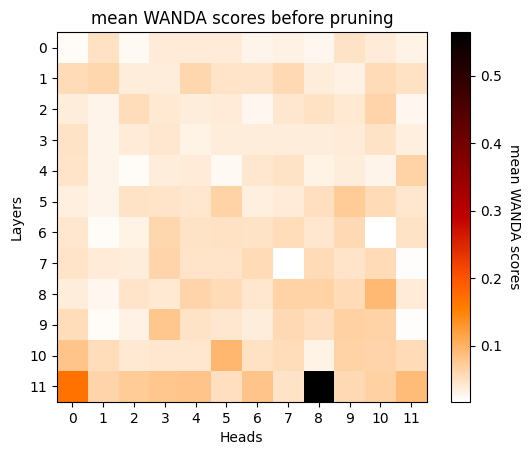

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import imshow
from utils.Visualization import outline_IoU, outline_IOI

                
for sub_layer_idx in range(scores_before_pruning.shape[0]):
    print("plot WANDA scores for sublayer:", args.target_layers[sub_layer_idx])
    
    fig, ax = plt.subplots()
    im = ax.imshow(scores_before_pruning[sub_layer_idx], cmap="gist_heat_r")#, norm=mpl.colors.CenteredNorm())
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("mean WANDA scores", rotation=-90, va="bottom")
    ax.set_yticks(np.arange(0, hooked_model.cfg.n_layers))
    ax.set_xticks(np.arange(0, hooked_model.cfg.n_heads))
    ax.set_ylabel("Layers")
    ax.set_xlabel("Heads")
    ax.set_title("mean WANDA scores before pruning")


    ax = outline_IOI(scores_before_pruning[sub_layer_idx], GTT_CIRCUIT, ax)

    fig.set_figheight(6)
    fig.set_figwidth(7)
    plt.show()

for sub_layer_idx in range(scores_after_pruning.shape[0]):
    print("plot WANDA scores for sublayer:", args.target_layers[sub_layer_idx])

    
    fig, ax = plt.subplots()
    im = ax.imshow(scores_after_pruning[sub_layer_idx],  cmap="gist_heat_r")#, norm=mpl.colors.CenteredNorm())
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("mean WANDA scores", rotation=-90, va="bottom")
    ax.set_yticks(np.arange(0, hooked_model.cfg.n_layers))
    ax.set_xticks(np.arange(0, hooked_model.cfg.n_heads))
    ax.set_ylabel("Layers")
    ax.set_xlabel("Heads")
    ax.set_title("mean WANDA scores after pruning")

    ax = outline_IOI(scores_after_pruning[sub_layer_idx], GTT_CIRCUIT, ax)


    fig.set_figheight(6)
    fig.set_figwidth(7)
    plt.show()

plot WANDA scores for sublayer: ['attn.hook_z']
torch.Size([1, 12, 12])


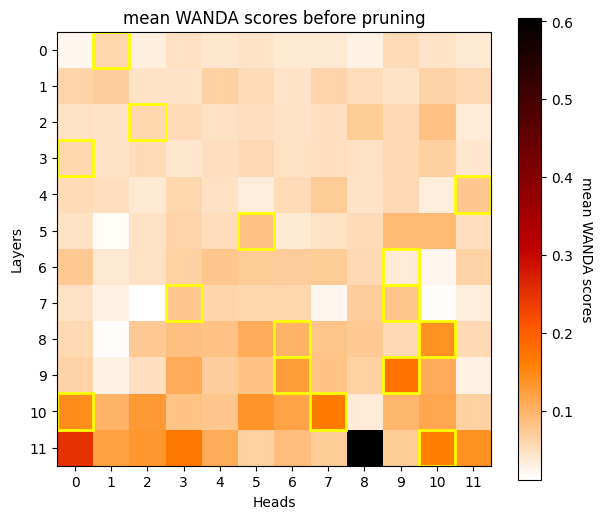

plot WANDA scores for sublayer: ['attn.hook_z']


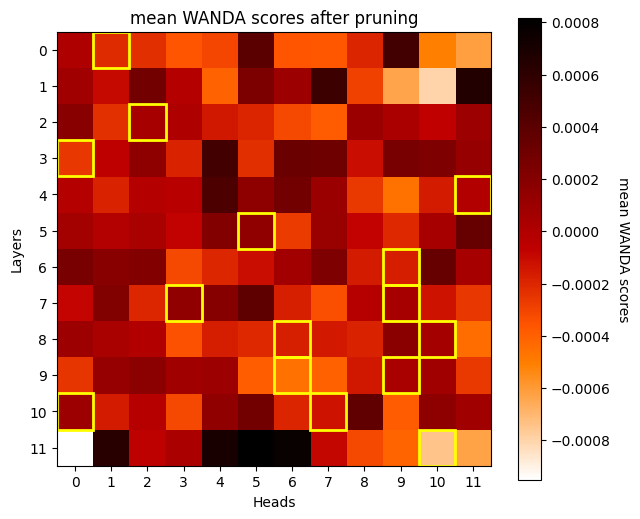

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import imshow
from OWL.lib.visual import outline_IoU, outline_IOI

                
#for sub_layer_idx in range(scores_before_pruning.shape[0]):
print("plot WANDA scores for sublayer:", args.target_layers)
print(scores_before_pruning.shape)
sbp = scores_before_pruning.mean(dim=[0])

fig, ax = plt.subplots()
im = ax.imshow(sbp, cmap="gist_heat_r")#, norm=mpl.colors.CenteredNorm())
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("mean WANDA scores", rotation=-90, va="bottom")
ax.set_yticks(np.arange(0, hooked_model.cfg.n_layers))
ax.set_xticks(np.arange(0, hooked_model.cfg.n_heads))
ax.set_ylabel("Layers")
ax.set_xlabel("Heads")
ax.set_title("mean WANDA scores before pruning")


ax = outline_IOI(sbp, IOI_CIRCUIT, ax)

fig.set_figheight(6)
fig.set_figwidth(7)
plt.show()

#for sub_layer_idx in range(scores_after_pruning.shape[0]):
print("plot WANDA scores for sublayer:", args.target_layers)

sap = scores_after_pruning.mean(dim=[0])
fig, ax = plt.subplots()
im = ax.imshow(sap,  cmap="gist_heat_r")#, norm=mpl.colors.CenteredNorm())
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("mean WANDA scores", rotation=-90, va="bottom")
ax.set_yticks(np.arange(0, hooked_model.cfg.n_layers))
ax.set_xticks(np.arange(0, hooked_model.cfg.n_heads))
ax.set_ylabel("Layers")
ax.set_xlabel("Heads")
ax.set_title("mean WANDA scores after pruning")

ax = outline_IOI(sap, IOI_CIRCUIT, ax)


fig.set_figheight(6)
fig.set_figwidth(7)
plt.show()

## Main

In [16]:
from Pruning.OWL.lib.prune_all import prune_heads_OWL #,prune_wanda_outlier
from Pruning.OWL.lib.prune_all_hooked import sparsity_ratio

model_name = args.model.split("/")[-1]
print(f"loading llm model {args.model}")
model = get_llm(args.model, args.cache_dir,device, args.dataset_name)


print ("model is =================================================================================")
print (model.__class__.__name__)
args.verbose = True

model.eval()
model.training=False
#args.prune_method = "magnitude_owl"
args.prune_method = "else"

##############################################
#args.target_layers=["attn.c_attn", "attn.c_proj", "mlp.c_fc", "mlp.c_proj"]

args.target_layers=[ "attn.c_attn"]



if "llama" in args.model:
    tokenizer = LlamaTokenizer.from_pretrained(args.model, use_fast=False)
    tokenizer.pad_token = tokenizer.eos_token
elif "gpt" in args.model:
    tokenizer = AutoTokenizer.from_pretrained("gpt2", force_download=False, use_fast=False)
    tokenizer.pad_token = tokenizer.eos_token


############################ owl   ############################
if args.prune_method == "magnitude_owl":
    # this is the original OWL
    prune_wanda_outlier(
        args, 
        None, 
        model, 
        tokenizer, 
        device, 
        prune_n=prune_n, 
        prune_m=prune_m, 
        dataset_name=args.dataset_name,

    )
    print("prune ehads old OWL")
    
else:
    prune_heads_OWL(
        args,
        None,
        model,
        tokenizer,
        device,
        prune_n=prune_n,
        prune_m=prune_m,
        dataset_name=args.dataset_name,
        per_sublayer=True
        )
    print("prune heads new OWL")

################################################################
print("*"*30)
sparsity = check_sparsity(model)
print(f"sparsity sanity check {sparsity:.4f}")
print("*"*30)
################################################################


loading llm model gpt2
cache_dir:  /mnt/qb/work/eickhoff/esx670
model is =================================================================================
GPT2LMHeadModel
using different length!
1
################# layer 0
pruning layer 0 name attn.c_attn
name attn.c_attn
weights tensor([[0.4738, 0.0874, 0.0039,  ..., 0.2592, 0.1517, 0.4100],
        [0.2614, 0.1473, 0.0695,  ..., 0.0164, 0.2170, 0.1924],
        [0.0978, 0.2387, 0.3668,  ..., 0.1991, 0.1043, 0.2400],
        ...,
        [0.3237, 0.0770, 0.1235,  ..., 0.0335, 0.0827, 0.2170],
        [0.0483, 0.1492, 0.1660,  ..., 0.1455, 0.0533, 0.1470],
        [0.2235, 0.1507, 0.0480,  ..., 0.0333, 0.0071, 0.0557]])
activation tensor([[0.3468, 0.3362, 0.4627, 0.3899, 0.4237, 0.3371, 0.2361, 0.4148, 0.3839,
         0.3979]])
w_metric torch.Size([2304, 768])
w_metric tensor([[0.1643, 0.0294, 0.0018,  ..., 0.0991, 0.0731, 0.1671],
        [0.0906, 0.0495, 0.0321,  ..., 0.0063, 0.1045, 0.0784],
        [0.0339, 0.0803, 0.1697,  ..., 0

## Head Pruning

In [22]:
from utils.utils import load_dataset
import numpy as np
from Pruning.OWL.lib.prune_all_hooked import sublayer_statistics, sparsity_ratio
from utils.eval_circuit import *

unpruned_model = get_hooked_llm(args.model, device)
model_mean_ablation = get_hooked_llm(args.model, device)

tokenizer = AutoTokenizer.from_pretrained("gpt2", force_download=False, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

# load dataset
dataset = load_dataset(task=args.dataset_name, patching_method="path",tokenizer=tokenizer, N=40, device=device)

# logit diff of original model

## original model
logits_gt = unpruned_model(dataset.clean_tokens)
ave_logit_gt = ave_logit_diff(logits_gt, dataset.answer_tokens, dataset.target_idx.to(device))

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
device cpu
['Pat', 'Kit', 'Sky', 'Lux', 'Ash']


### Test: Run original OWL and check fatihfulness

In [30]:
#hooked_model.reset_hooks(including_permanent=True)
print(f"Average logit difference (IOI dataset, entire model): {ave_logit_gt:.4f} \n ")

hooked_model.reset_hooks(including_permanent=True)
logits_OWL = hooked_model(dataset.clean_tokens)

ave_logit_OWL = ave_logit_diff(logits_OWL,  dataset.answer_tokens, dataset.target_idx.to(device))
print(f"Average logit difference (OWL pruning HookedTransformer): {ave_logit_OWL:.4f}")
print(f"performance achieved {performance_achieved(ave_logit_gt, ave_logit_OWL):.2f}% \n")

logits_OWL_adapt = model(dataset.clean_tokens).logits
ave_logit_OWL_adapt = ave_logit_diff(logits_OWL_adapt,  dataset.answer_tokens, dataset.target_idx.to(device))
print(f"Average logit difference (adapted OWL pruning CausualLLM): {ave_logit_OWL_adapt:.4f}")
print(f"performance achieved {performance_achieved(ave_logit_gt, ave_logit_OWL_adapt):.2f}% \n")


Average logit difference (IOI dataset, entire model): 5.4791 
 
Average logit difference (OWL pruning HookedTransformer): 8.9843
performance achieved 36.02% 



NameError: name 'model' is not defined

### Fatihfulness in IOI paper

The circuit C is subset of nodes of the model M. Nodes that are not in C but in M are knocked out using $\textbf{mean ablation}$. The mean over activations of different (corrupted) activations are plugged in nodes not in the circuit C. 

Since positions vary over different datapoints, take the mean over activations with equal templates.

The faithfulness F is calculated by $F = |F(M) - F(C)|$. F(M) is the average logit difference: $F(M) = \mathbb{E} [f(C(X); X)]$ where X is the uncorrupted input.

#### Understanding the implemented functions
Only the z component is patched. The z component has shape [batch x seq x head_idx x head_dim]. 

In $\textbf{computed\_means\_by\_template()}$ datapoints of different shapes are grouped into template_groups, which are structurally equal.
For each layer and template group, the mean over the z-activations of each of the template groups is cacluated.  
The z component activation is transformer: 
[batch seq head_idx head_dim] -> [seq head_idx head_dim] via the mean operator. 

In $\textbf{get\_heads\_and\_posns\_to\_keep}$ returns a dctionary of the form {layer: mask}, where mask has the shape [batch seq head]. If a head and a seq = position is  to ablated set the value to 1, else 0. This calculation is done on the input varia bles circuit and seq_pos_to_keep.

The function $\textbf{add\_mean\_ablation\_hook}$ runs first the two prior function to obtain the means and the boolean mask deciding whihc heads, positions to keep. Furthermore permanent hooks are added to the model which plug in the mean activations in the knokedout components.


#### Changes for our Implementation
The IOI implementation relies heavily on exact knowledge of what each and every head is doing and which position this head is paying attention to. 
When running this function on other pruning/patching methods aswell as other tasks, we do not have this knwoledge.

$\textbf{Fixes}$:
1) Simply removing the heads_and_seq_to_keep argument.
2) Since most activations focus on "end" token position, only keep end token activation?

Change the functions, s.t they do not need seq_pos_tokens and the head_type (Duplicate, NameMover,...)


In [21]:
IOI_CIRCUIT_ORIG = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "name mover": "end",
    "backup name mover": "end",
    "negative name mover": "end",
    "s2 inhibition": "end",
    "induction": "S2",
    "duplicate token": "S2",
    "previous token": "S1+1",
}

IOI_CIRCUIT_BACKUP_HEADS = {
    11: [2, 9, 10],
    10: [0, 1, 2, 6, 7, 10], 
    9:  [0, 9, 6, 7],
    8:  [6, 10],
    7:  [3, 9],
    6:  [9],
    5:  [5, 8, 9],    
    4:  [11],
    3:  [0],
    2:  [2], 
    0:  [1, 10]
}

IOI_CIRCUIT = {
    11: [10],
    10: [0, 7], 
    9:  [9, 6],
    8:  [6, 10],
    7:  [3, 9],
    6:  [9],
    5:  [5],    
    4:  [11],
    3:  [0],
    2:  [2], 
    0:  [1]
}

n_removed = 1
rem_layer = torch.randint(model_mean_ablation.cfg.n_layers, size=(n_removed,)).item()
rem_head = torch.randint(model_mean_ablation.cfg.n_heads, size=(n_removed,)).item()

TEST_CIRCUIT={}
for layer in range(model_mean_ablation.cfg.n_layers):
    TEST_CIRCUIT[layer] = list(range(model_mean_ablation.cfg.n_heads))
    if rem_layer == layer:
        TEST_CIRCUIT[layer].remove(rem_head)

model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=TEST_CIRCUIT,
    original_IOI=False
)
logits_test = model_mean_ablation(dataset.clean_tokens)
ave_logit_test = ave_logit_diff(logits_test,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))

print(f"Average logit difference (IOI dataset, using entire model): {ave_logit_gt:.4f}")
print(f"Average logit difference (IOI dataset, test circuit -- adapted): {ave_logit_test:.4f}")


## knockout via IOI paper method
model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=IOI_CIRCUIT_ORIG,
    seq_pos_to_keep=SEQ_POS_TO_KEEP,
    original_IOI=True
)
logits_minimal_original = model_mean_ablation(dataset.clean_tokens)
model_mean_ablation.reset_hooks(including_permanent=True)
ave_logits_orig = ave_logit_diff(logits_minimal_original,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))


Average logit difference (IOI dataset, using entire model): 3.9771
Average logit difference (IOI dataset, test circuit -- adapted): 3.9157


AttributeError: 'Dataset' object has no attribute 'word_idx'

In [24]:
IOI_CIRCUIT_ORIG = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "name mover": "end",
    "backup name mover": "end",
    "negative name mover": "end",
    "s2 inhibition": "end",
    "induction": "S2",
    "duplicate token": "S2",
    "previous token": "S1+1",
}

IOI_CIRCUIT_BACKUP_HEADS = {
    11: [2, 9, 10],
    10: [0, 1, 2, 6, 7, 10], 
    9:  [0, 9, 6, 7],
    8:  [6, 10],
    7:  [3, 9],
    6:  [9],
    5:  [5, 8, 9],    
    4:  [11],
    3:  [0],
    2:  [2], 
    0:  [1, 10]
}

IOI_CIRCUIT = {
    11: [10],
    10: [0, 7], 
    9:  [9, 6],
    8:  [6, 10],
    7:  [3, 9],
    6:  [9],
    5:  [5],    
    4:  [11],
    3:  [0],
    2:  [2], 
    0:  [1]
}

n_removed = 1
rem_layer = torch.randint(model_mean_ablation.cfg.n_layers, size=(n_removed,)).item()
rem_head = torch.randint(model_mean_ablation.cfg.n_heads, size=(n_removed,)).item()

TEST_CIRCUIT={}
for layer in range(model_mean_ablation.cfg.n_layers):
    TEST_CIRCUIT[layer] = list(range(model_mean_ablation.cfg.n_heads))
    if rem_layer == layer:
        TEST_CIRCUIT[layer].remove(rem_head)

ave_logit_test, performance_test = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=TEST_CIRCUIT,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )


gain_test = performance_gain(performance_new=performance, performance_old=performance_test)

print_statics(
    title="*********** IOI CIRCUIT ONE HEAD REMOVED  **************",
    ave_logit=ave_logit, 
    performance_achieved=performance_test,
    CIRCUIT=TEST_CIRCUIT, 
    IOI_CIRCUIT=IOI_CIRCUIT,
    #IOI_CIRCUIT=GTT_CIRCUIT_NO_NEG,
    performance_gain=gain_test
    )

## knockout via IOI paper method
model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=IOI_CIRCUIT_ORIG,
    seq_pos_to_keep=SEQ_POS_TO_KEEP,
    original_IOI=True
)
logits_minimal_original = model_mean_ablation(dataset.clean_tokens)
model_mean_ablation.reset_hooks(including_permanent=True)
ave_logits_orig = ave_logit_diff(logits_minimal_original,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))


NameError: name 'performance' is not defined

### Greater Than Circuit

In [33]:

dataset = load_dataset(prepend_bos=False, task="GreaterThan", patching_method="path",tokenizer=tokenizer, N=40, device=device)

GTT_CIRCUIT = {
    10: [7],    # not including this head almost doubles performance
    9: [1],
    8: [11], 
    7: [10],
    6: [9], 
    5: [1, 5, 8], 
    4: [7, 11],
    3: [7],
    2: [1],
    1: [11],
    0: [1, 5, 7]
}


ave_logit_GTT, performance_GTT = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=GTT_CIRCUIT,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

print_statics(
    title="*********** GTT CIRCUIT **************",
    ave_logit=ave_logit_GTT, 
    performance_achieved=performance_GTT,
    CIRCUIT=GTT_CIRCUIT, 
    IOI_CIRCUIT=GTT_CIRCUIT
    )


GTT_CIRCUIT_NO_NEG = {
    #10: [7],    # not including this head almost doubles performance
    9: [1],
    8: [11], 
    7: [10],
    6: [9], 
    5: [1, 5], #8], 
    4: [7], #11],
    3: [7],
    2: [1],
    #1: [11],
    0: [1,5, 7]
}


ave_logit_GTT_NO_NEG, performance_GTT_NO_NEG = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=GTT_CIRCUIT_NO_NEG,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

print_statics(
    title="*********** GTT CIRCUIT (MANUAL)  WITHOUT NEGATIVE INFLUENCES **************",
    ave_logit=ave_logit_GTT_NO_NEG, 
    performance_achieved=performance_GTT_NO_NEG,
    CIRCUIT=GTT_CIRCUIT_NO_NEG, 
    IOI_CIRCUIT=GTT_CIRCUIT_NO_NEG
    )


"""
Circuit of Paper
"How does GPT-2 compute greater-than?: Interpreting
mathematical abilities in a pre-trained language model" without MLPs
"""

GTT_PAPER_CIRCUIT = {
    9: [1], 
    8: [8, 11], 
    8: [8], 
    7: [10],
    6: [9], 
    5: [5, 1]   
}
ave_logit_GTT_ORIG, performance_GTT_ORIG = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=GTT_PAPER_CIRCUIT,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

print_statics(
    title="*********** GTT CIRCUIT FROM PAPER **************",
    ave_logit=ave_logit_GTT_ORIG, 
    performance_achieved=performance_GTT_ORIG,
    CIRCUIT=GTT_PAPER_CIRCUIT, 
    IOI_CIRCUIT=GTT_PAPER_CIRCUIT
    )


device cpu
*********** GTT CIRCUIT **************
Average logit difference: 4.7405
circuit size: 16
performance achieved: 86.61%
IoU: 100.00%

*********** GTT CIRCUIT (MANUAL)  WITHOUT NEGATIVE INFLUENCES **************
Average logit difference: 4.8165
circuit size: 12
performance achieved: 88.00%
IoU: 100.00%

*********** GTT CIRCUIT FROM PAPER **************
Average logit difference: 4.3565
circuit size: 6
performance achieved: 79.60%
IoU: 100.00%



*********** OWL CIRCUIT on Greater Than Task **************
Average logit difference: 5.4732
circuit size: 144
performance achieved: 100.00%
IoU: 11.11%
performance gain 15.46%



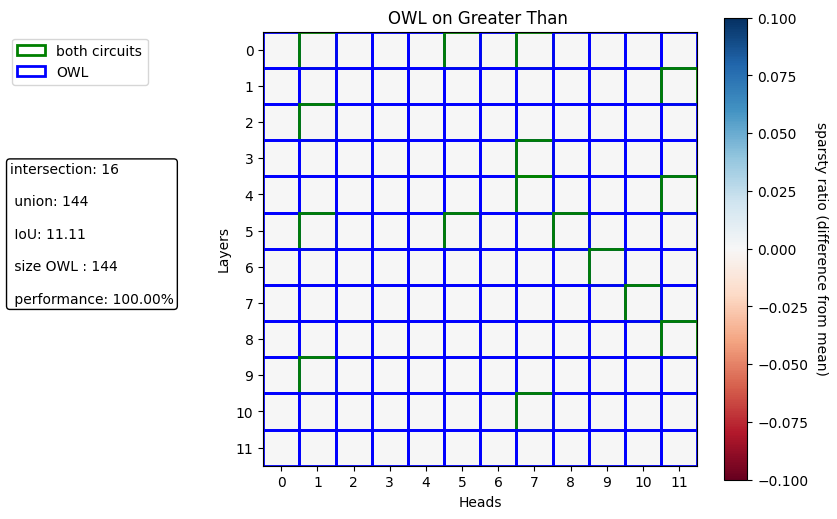

In [43]:
from Pruning.OWL.lib.prune_all_hooked import sublayer_statistics, sparsity_ratio
from utils.Visualization import heat_map_sparsity

W_O = hooked_model.W_Q
sparsities =  np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))

for layer in range(hooked_model.cfg.n_layers):
    head_sparisty = []
    for head in range(hooked_model.cfg.n_heads):
        head_sparsity_ratio = sparsity_ratio(W_O[layer][head],value=0)
        head_sparisty.append(head_sparsity_ratio)
    sparsities[layer] = head_sparisty
#best scaler=0.38

scaler=1 #-> high intersection on the late layers!
#scaler=9  #for hoook_input_q

W_O_total_mean = np.mean(sparsities)
W_O_total_std = np.std(head_sparisty)
#print("std", W_O_total_std)

CIRCUIT_PRUNING_GLOBAL = {}
for layer in range(hooked_model.cfg.n_layers):
    CIRCUIT_PRUNING_GLOBAL[layer] = []
    for head_idx in range(hooked_model.cfg.n_heads):
        # if indicidual head has more weights pruned than the total mean, the difference will be negative and the head immediatelly pruned
        # a head is only in the circuit, if it prunes (significantly) less weights than average 
        # (#pruned_weights_in_head) << (average_pruned_weights_in_model)
        
        diff_from_mean =  W_O_total_mean  - sparsities[layer, head_idx]

        if diff_from_mean >= scaler * W_O_total_std:
            CIRCUIT_PRUNING_GLOBAL[layer].append(head_idx)
# print("CIRCUIT PRUNING", CIRCUIT_PRUNING_GLOBAL)
sparsties_diff = sparsities - W_O_total_mean


ave_logit, performance = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=CIRCUIT_PRUNING_GLOBAL,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

gain = performance_gain(performance_new=performance, performance_old=performance_GTT)

print_statics(
    title="*********** OWL CIRCUIT on Greater Than Task **************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT_PRUNING_GLOBAL, 
    IOI_CIRCUIT=GTT_CIRCUIT,
    #IOI_CIRCUIT=GTT_CIRCUIT_NO_NEG,
    performance_gain=gain
    )

fig = heat_map_sparsity(
    sparsties_diff, 
    GTT_CIRCUIT,
    #GTT_CIRCUIT_NO_NEG,
    CIRCUIT_PRUNING_GLOBAL, 
    title=f"OWL on Greater Than ",
    title_eval_circuit="OWL",
    title_compare_circuit="GTT Circuit",
    performance=performance,
    print_vals=False)

fig.show()


#sparsties_diff = sparsities - W_O_total_mean
#heat_map_sparsity(sparsties_diff, GTT_CIRCUIT,CIRCUIT_PRUNING_GLOBAL, title="spasity ratio: OWL-global vs IOI")
            

total std 0.1329905420628191
CIRCUIT PRUNING {0: [], 1: [], 2: [2], 3: [], 4: [1, 11], 5: [7], 6: [], 7: [8], 8: [3, 10], 9: [1, 9], 10: [2, 7], 11: [0, 8]}
*********** FLAP CIRCUIT vs GTT CIRCUIT **************
Average logit difference: 2.0639
circuit size: 13
performance achieved: 37.71%
IoU: 11.54%
performance gain -56.46%



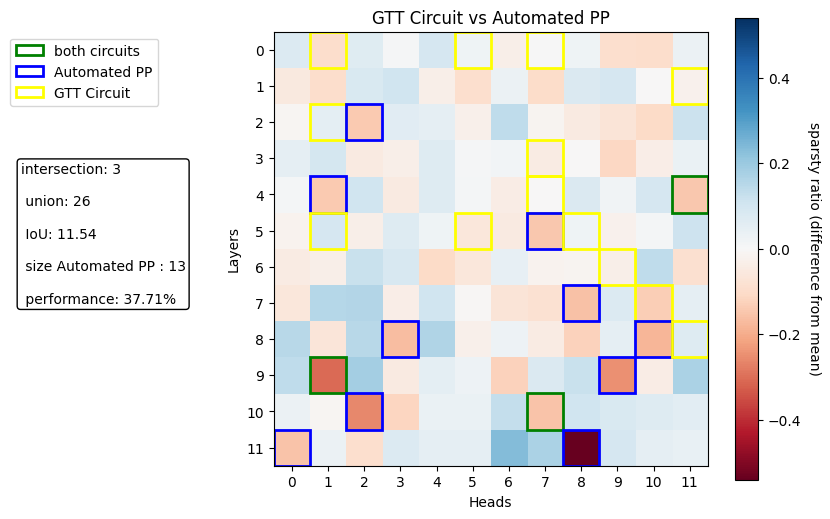

In [ ]:
from utils.Visualization import heat_map_sparsity


W_O = hooked_model.W_O
sparsities =  np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))
sparsties_diff = np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))

for layer in range(hooked_model.cfg.n_layers):
    head_sparisty = []
    for head in range(hooked_model.cfg.n_heads):
        head_sparsity_ratio = sparsity_ratio(W_O[layer][head],value=0.0)
        head_sparisty.append(head_sparsity_ratio)
    sparsities[layer] = head_sparisty


#scaler=10 #-> hook_q_input
scaler=0.7
#scaler=0.5 #-> hook_q_input


total_std = np.std(head_sparisty)

CIRCUIT_PRUNING_LOCAL = {}
for layer in range(hooked_model.cfg.n_layers):
    CIRCUIT_PRUNING_LOCAL[layer] = []
    for head_idx in range(hooked_model.cfg.n_heads):
        
        diff_from_mean =  np.mean(sparsities[layer]) - sparsities[layer, head_idx]
        sparsties_diff[layer, head_idx] = -diff_from_mean

        if  diff_from_mean >= scaler * total_std:
            CIRCUIT_PRUNING_LOCAL[layer].append(head_idx)
            
print("total std", scaler * total_std)            

print("CIRCUIT PRUNING", CIRCUIT_PRUNING_LOCAL)


ave_logit, performance = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=CIRCUIT_PRUNING_LOCAL,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

gain = performance_gain(performance_new=performance, performance_old=performance_GTT)

print_statics(
    title="*********** FLAP CIRCUIT vs GTT CIRCUIT **************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT_PRUNING_LOCAL, 
    IOI_CIRCUIT=GTT_CIRCUIT,
    #IOI_CIRCUIT=GTT_CIRCUIT_NO_NEG,
    performance_gain=gain
    )

fig = heat_map_sparsity(
    sparsties_diff, 
    GTT_CIRCUIT,
    #GTT_CIRCUIT_NO_NEG,
    CIRCUIT_PRUNING_LOCAL, 
    title=f"GTT Circuit vs Automated PP",
    title_eval_circuit="Automated PP",
    title_compare_circuit="GTT Circuit",
    performance=performance,
    print_vals=False)

fig.show()



In [70]:
from utils.eval_circuit import *
from Pruning.OWL.lib.eval import *
model_mean_ablation.seqlen = 22

## knockout via IOI paper method
model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=IOI_CIRCUIT_BACKUP_HEADS,
)
logits_original = model_mean_ablation(dataset.clean_tokens)
ave_logits_orig = ave_logit_diff(logits_original,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))
print(f"Average logit difference (IOI dataset, IOI circuit with backup heads): {ave_logits_orig:.4f}")
print(F"performance achieved", performance_achieved(ave_logit_gt, ave_logits_orig))


## knockout new method, without seq_pos_to_keep dic
model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=IOI_CIRCUIT
)
logits_adapt = model_mean_ablation(dataset.clean_tokens)
ave_logits_adapat = ave_logit_diff(logits_adapt,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))

print(f"Average logit difference (IOI dataset, IOI circuit no backup heads): {ave_logits_adapat:.4f}")
print(F"performance achieved", performance_achieved(ave_logit_gt, ave_logits_adapat))


Average logit difference (IOI dataset, IOI circuit with backup heads): -0.4397
performance achieved -11.055300300812476
Average logit difference (IOI dataset, IOI circuit no backup heads): -0.8966
performance achieved -22.54353969571774


### Induction Circuit

In [24]:
from utils.utils import load_dataset
from utils.eval_circuit import *

dataset = load_dataset(prepend_bos=False, task="induction", patching_method="path",tokenizer=tokenizer, N=40, device=device)

INDUCTION_CIRCUIT = {
    11: [6],    
    9: [9], 
    7: [10],
    6: [9], 
    5: [5], 
    3: [0],
    0: [10]
}


ave_logit_ind, performance_ind = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=INDUCTION_CIRCUIT,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

print_statics(
    title="*********** INDUCTION CIRCUIT **************",
    ave_logit=ave_logit_ind, 
    performance_achieved=performance_ind,
    CIRCUIT=INDUCTION_CIRCUIT, 
    IOI_CIRCUIT=INDUCTION_CIRCUIT
    )

device cpu
length of names 39
*********** INDUCTION CIRCUIT **************
Average logit difference: 12.1053
circuit size: 7
performance achieved: -20.94%
IoU: 100.00%



*********** OWL CIRCUIT on Induction Task **************
Average logit difference: 9.4777
circuit size: 15
performance achieved: 26.84%
IoU: 10.00%
performance gain -226.74%



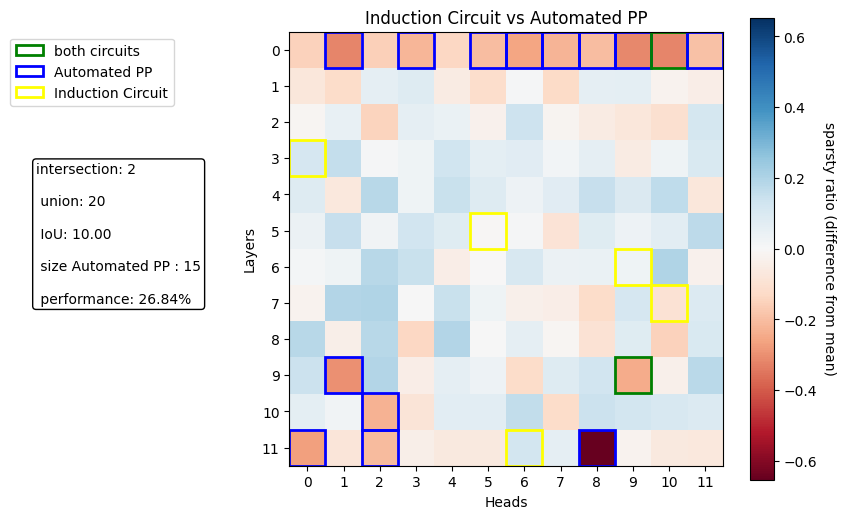

In [54]:
#from OWL.lib.prune_all_hooked import sublayer_statistics, sparsity_ratio
from utils.Visualization import heat_map_sparsity

W_O = hooked_model.W_O
sparsities =  np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))

for layer in range(hooked_model.cfg.n_layers):
    head_sparisty = []
    for head in range(hooked_model.cfg.n_heads):
        head_sparsity_ratio = sparsity_ratio(W_O[layer][head],value=0)
        head_sparisty.append(head_sparsity_ratio)
    sparsities[layer] = head_sparisty
#best scaler=0.38

scaler=1 #-> high intersection on the late layers!
#scaler=9  #for hoook_input_q

W_O_total_mean = np.mean(sparsities)
W_O_total_std = np.std(head_sparisty)
#print("std", W_O_total_std)

CIRCUIT_PRUNING_GLOBAL = {}
for layer in range(hooked_model.cfg.n_layers):
    CIRCUIT_PRUNING_GLOBAL[layer] = []
    for head_idx in range(hooked_model.cfg.n_heads):
        # if indicidual head has more weights pruned than the total mean, the difference will be negative and the head immediatelly pruned
        # a head is only in the circuit, if it prunes (significantly) less weights than average 
        # (#pruned_weights_in_head) << (average_pruned_weights_in_model)
        
        diff_from_mean =  W_O_total_mean  - sparsities[layer, head_idx]

        if diff_from_mean >= scaler * W_O_total_std:
            CIRCUIT_PRUNING_GLOBAL[layer].append(head_idx)
# print("CIRCUIT PRUNING", CIRCUIT_PRUNING_GLOBAL)
sparsties_diff = sparsities - W_O_total_mean


ave_logit, performance = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=CIRCUIT_PRUNING_GLOBAL,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

gain = performance_gain(performance_new=performance, performance_old=performance_ind)

print_statics(
    title="*********** OWL CIRCUIT on Induction Task **************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT_PRUNING_GLOBAL, 
    IOI_CIRCUIT=INDUCTION_CIRCUIT,
    performance_gain=gain
    )

fig = heat_map_sparsity(
    sparsties_diff, 
    INDUCTION_CIRCUIT,
    CIRCUIT_PRUNING_GLOBAL, 
    title=f"Induction Circuit vs Automated PP",
    title_eval_circuit="Automated PP",
    title_compare_circuit="Induction Circuit",
    performance=performance,
    print_vals=False)

fig.show()


#sparsties_diff = sparsities - W_O_total_mean
#heat_map_sparsity(sparsties_diff, GTT_CIRCUIT,CIRCUIT_PRUNING_GLOBAL, title="spasity ratio: OWL-global vs IOI")
            

total std 0.11399189319670208
CIRCUIT PRUNING {0: [], 1: [], 2: [2], 3: [], 4: [1, 11], 5: [7], 6: [], 7: [8, 10], 8: [3, 8, 10], 9: [1, 6, 9], 10: [2, 3, 7], 11: [0, 8]}
***********OWL CIRCUIT on Induction Task **************
Average logit difference: 8.8032
circuit size: 17
performance achieved: 39.16%
IoU: 9.09%
performance gain -284.95%



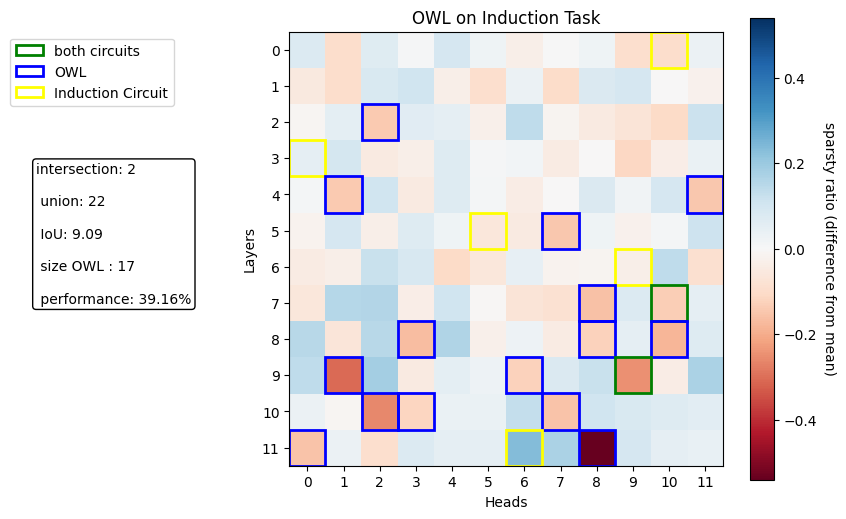

In [56]:
from utils.Visualization import heat_map_sparsity


W_O = hooked_model.W_O
sparsities =  np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))
sparsties_diff = np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))

for layer in range(hooked_model.cfg.n_layers):
    head_sparisty = []
    for head in range(hooked_model.cfg.n_heads):
        head_sparsity_ratio = sparsity_ratio(W_O[layer][head],value=0.0)
        head_sparisty.append(head_sparsity_ratio)
    sparsities[layer] = head_sparisty


#scaler=10 #-> hook_q_input
scaler=0.6
#scaler=0.5 #-> hook_q_input


total_std = np.std(head_sparisty)

CIRCUIT_PRUNING_LOCAL = {}
for layer in range(hooked_model.cfg.n_layers):
    CIRCUIT_PRUNING_LOCAL[layer] = []
    for head_idx in range(hooked_model.cfg.n_heads):
        
        diff_from_mean =  np.mean(sparsities[layer]) - sparsities[layer, head_idx]
        sparsties_diff[layer, head_idx] = -diff_from_mean

        if  diff_from_mean >= scaler * total_std:
            CIRCUIT_PRUNING_LOCAL[layer].append(head_idx)
            
print("total std", scaler * total_std)            

print("CIRCUIT PRUNING", CIRCUIT_PRUNING_LOCAL)


ave_logit, performance = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=CIRCUIT_PRUNING_LOCAL,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

gain = performance_gain(performance_new=performance, performance_old=performance_ind)

print_statics(
    title="***********OWL CIRCUIT on Induction Task **************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT_PRUNING_LOCAL, 
    IOI_CIRCUIT=INDUCTION_CIRCUIT,
    performance_gain=gain
    )

fig = heat_map_sparsity(
    sparsties_diff, 
    INDUCTION_CIRCUIT,
    CIRCUIT_PRUNING_LOCAL, 
    title=f"OWL on Induction Task",
    title_eval_circuit="OWL",
    title_compare_circuit="Induction Circuit",
    performance=performance,
    print_vals=False)

fig.show()



## Gendered Pronoun Task

In [ ]:
GPT_CIRCUIT = {
    10: [9], 
    9: [7], 
    6: [0], 
    4: [3, 7],
    3: [6],
    2: [2, 9],
    0: [1] 
}
ave_logit_GPT, performance_GPT = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=GPT_CIRCUIT,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

print_statics(
    title="*********** Gendered Pronouns CIRCUIT (Manual PP) **************",
    ave_logit=ave_logit_GPT, 
    performance_achieved=performance_GPT,
    CIRCUIT=GPT_CIRCUIT, 
    IOI_CIRCUIT=GPT_CIRCUIT
    )



# paper at:
#https://cdn.prod.website-files.com/634e78132252d2b0203a9ac8/63d12ba41401c7a1cc9bbf84_Hackathon_Report_Chris_Guillaume.pdf
# carefull, path patching is done here a  little bit different. Not only heads and "qkv" positions
# are tested but also for sequence position "name", "is", "t"

GPT_CIRCUIT_PAPER = {
    10: [9], 
    9: [7], 
    6: [0], 
    4: [3],
    2: [6],
    1: [4],
    0: [4]    
}

ave_logit_GPT_paper, performance_GPT_paper = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=GPT_CIRCUIT_PAPER,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

print_statics(
    title="*********** Gendered Pronouns CIRCUIT (Paper) **************",
    ave_logit=ave_logit_GPT_paper, 
    performance_achieved=performance_GPT_paper,
    CIRCUIT=GPT_CIRCUIT_PAPER, 
    IOI_CIRCUIT=GPT_CIRCUIT_PAPER
    )



*********** Gendered Pronouns CIRCUIT (Manual PP) **************
Average logit difference: 7.8454
circuit size: 9
performance achieved: 56.81%
IoU: 100.00%

*********** Gendered Pronouns CIRCUIT (Paper) **************
Average logit difference: 7.7151
circuit size: 7
performance achieved: 59.19%
IoU: 100.00%



*********** OWL CIRCUIT (GLOBAL) on Gendered Pronouns Task **************
Average logit difference: 8.8974
circuit size: 42
performance achieved: 37.61%
IoU: 0.00%
performance gain -33.80%



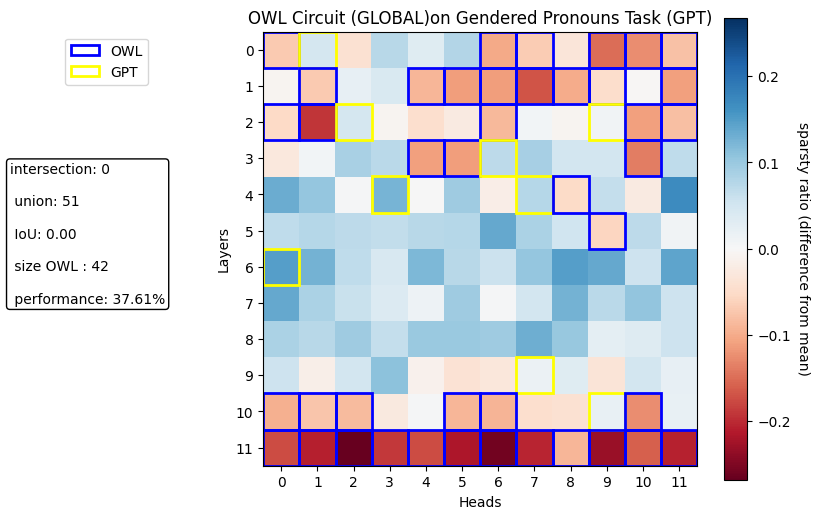

In [38]:
#from OWL.lib.prune_all_hooked import sublayer_statistics, sparsity_ratio
from utils.Visualization import heat_map_sparsity

W_O = hooked_model.W_V
sparsities =  np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))

for layer in range(hooked_model.cfg.n_layers):
    head_sparisty = []
    for head in range(hooked_model.cfg.n_heads):
        head_sparsity_ratio = sparsity_ratio(W_O[layer][head],value=0)
        head_sparisty.append(head_sparsity_ratio)
    sparsities[layer] = head_sparisty
#best scaler=0.38

scaler=1 #-> high intersection on the late layers!
#scaler=9  #for hoook_input_q

W_O_total_mean = np.mean(sparsities)
W_O_total_std = np.std(head_sparisty)
#print("std", W_O_total_std)

CIRCUIT_PRUNING_GLOBAL = {}
for layer in range(hooked_model.cfg.n_layers):
    CIRCUIT_PRUNING_GLOBAL[layer] = []
    for head_idx in range(hooked_model.cfg.n_heads):
        # if indicidual head has more weights pruned than the total mean, the difference will be negative and the head immediatelly pruned
        # a head is only in the circuit, if it prunes (significantly) less weights than average 
        # (#pruned_weights_in_head) << (average_pruned_weights_in_model)
        
        diff_from_mean =  W_O_total_mean  - sparsities[layer, head_idx]

        if diff_from_mean >= scaler * W_O_total_std:
            CIRCUIT_PRUNING_GLOBAL[layer].append(head_idx)
# print("CIRCUIT PRUNING", CIRCUIT_PRUNING_GLOBAL)
sparsties_diff = sparsities - W_O_total_mean


ave_logit, performance = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=CIRCUIT_PRUNING_GLOBAL,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

gain = performance_gain(performance_new=performance, performance_old=performance_GPT)

print_statics(
    title="*********** OWL CIRCUIT (GLOBAL) on Gendered Pronouns Task **************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT_PRUNING_GLOBAL, 
    IOI_CIRCUIT=GPT_CIRCUIT,
    performance_gain=gain
    )

fig = heat_map_sparsity(
    sparsties_diff, 
    GPT_CIRCUIT,
    CIRCUIT_PRUNING_GLOBAL, 
    title=f"OWL Circuit (GLOBAL)on Gendered Pronouns Task (GPT)",
    title_eval_circuit="OWL",
    title_compare_circuit="GPT",
    performance=performance,
    print_vals=False)

fig.show()


#sparsties_diff = sparsities - W_O_total_mean
#heat_map_sparsity(sparsties_diff, GTT_CIRCUIT,CIRCUIT_PRUNING_GLOBAL, title="spasity ratio: OWL-global vs IOI")
            

total std 0.04561827999876991
CIRCUIT PRUNING {0: [6, 9, 10], 1: [5, 6, 7, 11], 2: [1, 10], 3: [4, 5, 10], 4: [2, 4, 6, 8, 10], 5: [9, 11], 6: [3, 10], 7: [4, 6], 8: [9, 10], 9: [5, 6, 9], 10: [10], 11: [2, 6]}
*********** OWL CIRCUIT (LOCAL) on Gendered Pronouns Task **************
Average logit difference: 8.8974
circuit size: 31
performance achieved: 37.61%
IoU: 0.00%
performance gain -33.80%



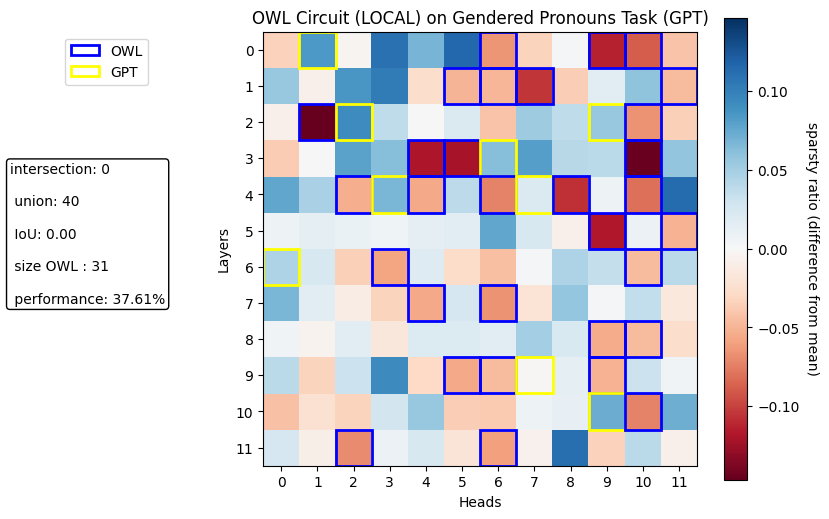

In [40]:
from utils.Visualization import heat_map_sparsity


W_O = hooked_model.W_V
sparsities =  np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))
sparsties_diff = np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))

for layer in range(hooked_model.cfg.n_layers):
    head_sparisty = []
    for head in range(hooked_model.cfg.n_heads):
        head_sparsity_ratio = sparsity_ratio(W_O[layer][head],value=0.0)
        head_sparisty.append(head_sparsity_ratio)
    sparsities[layer] = head_sparisty


#scaler=10 #-> hook_q_input
scaler=1
#scaler=0.5 #-> hook_q_input


total_std = np.std(head_sparisty)

CIRCUIT_PRUNING_LOCAL = {}
for layer in range(hooked_model.cfg.n_layers):
    CIRCUIT_PRUNING_LOCAL[layer] = []
    for head_idx in range(hooked_model.cfg.n_heads):
        
        diff_from_mean =  np.mean(sparsities[layer]) - sparsities[layer, head_idx]
        sparsties_diff[layer, head_idx] = -diff_from_mean

        if  diff_from_mean >= scaler * total_std:
            CIRCUIT_PRUNING_LOCAL[layer].append(head_idx)
            
print("total std", scaler * total_std)            

print("CIRCUIT PRUNING", CIRCUIT_PRUNING_LOCAL)

ave_logit, performance = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=CIRCUIT_PRUNING_GLOBAL,
    dataset=dataset,
    ave_logit_gt=ave_logit_gt
    )

gain = performance_gain(performance_new=performance, performance_old=performance_GPT)

print_statics(
    title="*********** OWL CIRCUIT (LOCAL) on Gendered Pronouns Task **************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT_PRUNING_LOCAL, 
    IOI_CIRCUIT=GPT_CIRCUIT,
    performance_gain=gain
    )

fig = heat_map_sparsity(
    sparsties_diff, 
    GPT_CIRCUIT,
    CIRCUIT_PRUNING_LOCAL, 
    title=f"OWL Circuit (LOCAL) on Gendered Pronouns Task (GPT)",
    title_eval_circuit="OWL",
    title_compare_circuit="GPT",
    performance=performance,
    print_vals=False)

fig.show()

loading llm model gpt2


/mnt/lustre/work/eickhoff/esx670/.conda/py-311-pytorch_clone1/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
Moving model to device:  cpu


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
GenderedPronoun
['Pat', 'Kit', 'Sky', 'Lux', 'Ash']
GenderedPronoun
['Pat', 'Kit', 'Sky', 'Lux', 'Ash']
std 0.01602373410005911
CIRCUIT PRUNING {0: [1, 3, 4, 5, 7], 1: [0, 1, 5, 6, 7, 11], 2: [1, 2, 3, 4, 5, 8, 9], 3: [0, 3, 9], 4: [11], 5: [0, 1, 5], 6: [1, 4, 9, 10], 7: [1, 2, 7, 10, 11], 8: [1, 3, 6], 9: [0, 2, 4, 9, 11], 10: [11], 11: [9, 10, 11]}


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
GenderedPronoun
['Pat', 'Kit', 'Sky', 'Lux', 'Ash']
GenderedPronoun
['Pat', 'Kit', 'Sky', 'Lux', 'Ash']
std 0.01603561275207125
CIRCUIT PRUNING {0: [0, 1, 2, 3, 4, 5, 7], 1: [0, 1, 5, 6, 7, 8, 9, 11], 2: [0, 1, 2, 4, 8], 3: [0, 3, 9], 4: [11], 5: [0, 1, 5], 6: [1, 4, 9, 10], 7: [1, 2, 7, 10, 11], 8: [1, 3, 6], 9: [4, 9, 11], 10: [11], 11: [9, 11]}


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
GenderedPronoun
['Pat', 'Kit', 'Sky', 'Lux', 'Ash']
GenderedPronoun
['Pat', 'Kit', 'Sky', 'Lux', 'Ash']
std 0.2090056971421219
CIRCUIT PRUNING {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [3, 10], 10: [5, 9], 11: [0, 8]}


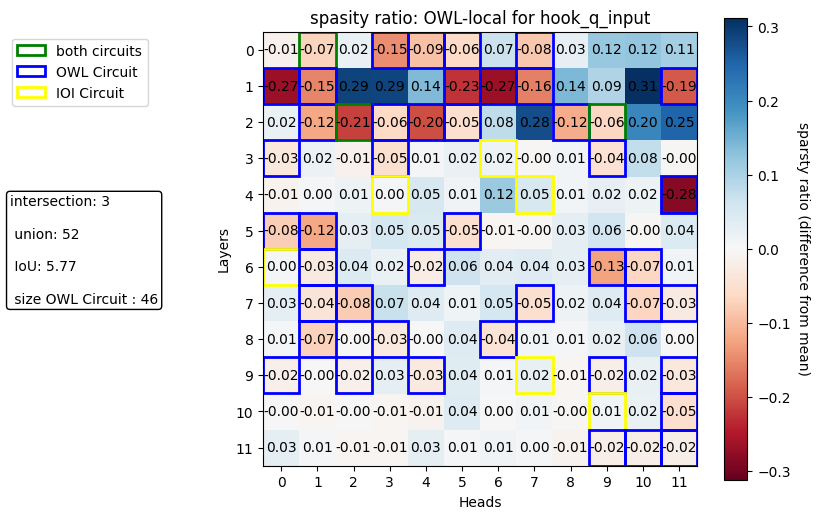

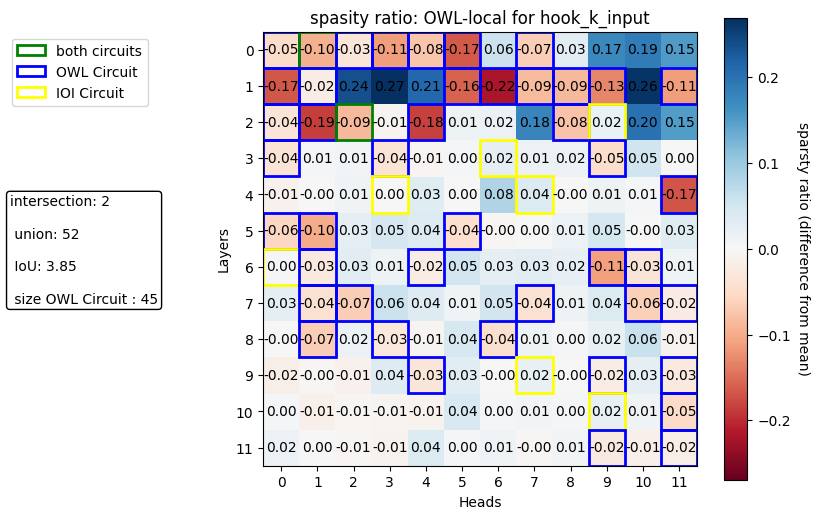

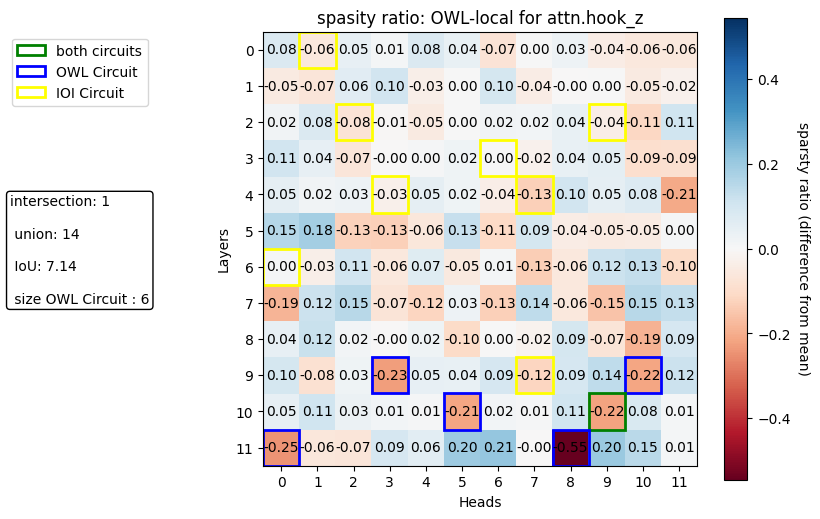

In [45]:
from Pruning.OWL.lib.prune_all_hooked import sublayer_statistics, sparsity_ratio
from utils.Visualization import heat_map_sparsity
from utils.eval_circuit import merge_circuits

torch.cuda.empty_cache()

model_name = args.model.split("/")[-1]
print(f"loading llm model {args.model}")

CIRCUIT_PRUNING_LOCAL = {}
args.verbose=False
all_sparsities = []

#hooks = ["hook_q_input", "hook_k_input", "hook_v_input", "attn.hook_z"]
hooks = ["hook_q_input", "hook_k_input",  "attn.hook_z"]
#hooks = ["hook_q_input","attn.hook_z"]
#for target in hooks:
args.N = 10
hooked_model = get_hooked_llm(args.model, device)
hooked_model.eval()
hooked_model.training=False
hooked_model.to(device)

    
args.seed= 6700098

for target in hooks:
    hooked_model = get_hooked_llm(args.model, device)
    args.target_layers=[target]
    OWL_corrupted_activ_pruning(
        args, 
        None, 
        hooked_model, 
        hooked_tokenizer, 
        device, 
        prune_n=prune_n, 
        prune_m=prune_m, 
        dataset_name=args.dataset_name,
        corrupt_knockout=True, 
        testing=False,
        per_sublayer=False,
        test_inps=None,
        head_pruning=False,
        head_pruning_by_score=False,
        scaler=0.78
        )

    if target == "hook_q_input" : 
        W = hooked_model.W_Q
        scaler=1

    elif target == "hook_k_input":
        W = hooked_model.W_K
        scaler=1
        
    elif target == "hook_v_input":
        W = hooked_model.W_V
        scaler=1.5
        
    elif target == "attn.hook_z":
        W = hooked_model.W_O
        scaler = 1
        
    sparsities =  np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))
    for layer in range(hooked_model.cfg.n_layers):
        head_sparisty = []
        for head in range(hooked_model.cfg.n_heads):
            head_sparsity_ratio = sparsity_ratio(W [layer][head],value=0)
            head_sparisty.append(head_sparsity_ratio)
        sparsities[layer] = head_sparisty

    all_sparsities.append(sparsities)

    # best scaler=0.38
    #scaler=1.25 -> high intersection on the late layers!

    total_std = np.std(head_sparisty)
    print("std", total_std)

    CIRCUIT_HOOK_LOCAL = {}
    for layer in range(hooked_model.cfg.n_layers):
        CIRCUIT_HOOK_LOCAL[layer] = []
        for head_idx in range(hooked_model.cfg.n_heads):
            # if indicidual head has more weights pruned than the total mean, the difference will be negative and the head immediatelly pruned
            # a head is only in the circuit, if it prunes (significantly) less weights than average 
            # (#pruned_weights_in_head) << (average_pruned_weights_in_model)
            
            diff_from_mean =  np.mean(sparsities[layer])  - sparsities[layer, head_idx]
            sparsties_diff[layer, head_idx] = -diff_from_mean
            if diff_from_mean >= scaler * total_std:
                CIRCUIT_HOOK_LOCAL[layer].append(head_idx)
    print("CIRCUIT PRUNING", CIRCUIT_HOOK_LOCAL)

    heat_map_sparsity(sparsties_diff, GPT_CIRCUIT, CIRCUIT_HOOK_LOCAL, title=f"spasity ratio: OWL-local for {target}")

    CIRCUIT_PRUNING_LOCAL = merge_circuits(CIRCUIT_PRUNING_LOCAL, CIRCUIT_HOOK_LOCAL)


## Faithfulness of OWL circuits

Using different methods to develop the OWL circuits:

Let $l$ be a layer of the model and let $h$ be a head of that layer.
Let $P_{l, h}$ be the number of pruned weights of head $h$ in layer $l$.
Let $\mathbb{E}[$P_{*, *}]$ be the mean over the number of pruned weights of all layers $l$ and all heads $i$.


1) after running OWL -> pruned globally (=over all layers), where 
$$\mathbb{E}[P_{*, *}] - P_{l, h} \geq 2* \mathrm{Var}[P_{*, *}]$$
-> This method is unreliable to use in OWL since the amount of pruned weights per layer depends on the OWL metric and is different for each layer. 
OWL strives for a layer sparsity ratio that is low in the beginning and the end and high in the middle. Thus when comparing to the global mean we never prune heads from early or late layers.

2) after running OWL -> prune locally, where 
$$\mathbb{E}[P_{l, *}] - P_{l, h}  \geq 2* \mathrm{Var}[P_{l, *}]$$


3) while running OWL -> prune locally, where
$$\mathbb{E}[P_{l, *}] - P_{l, h}  \geq 2* \mathrm{Var}[P_{l, *}]$$


#### 1) after running OWL, prune globally

Just keep the heads, that are at least scaler * SD lower than the mean.

Thus, if mean(X_all) - X_i >= scale * SD(X_all) = True
    

From this equation follows, that mean(X_all) > X_i and the difference between the mean and the head is at least SD(X_all)
If that is the case, the head is NOT PRUNED!!! (significantly less weights are pruned in head_i than they are overal). The head is added to the circuit



std 0.15247329711529384


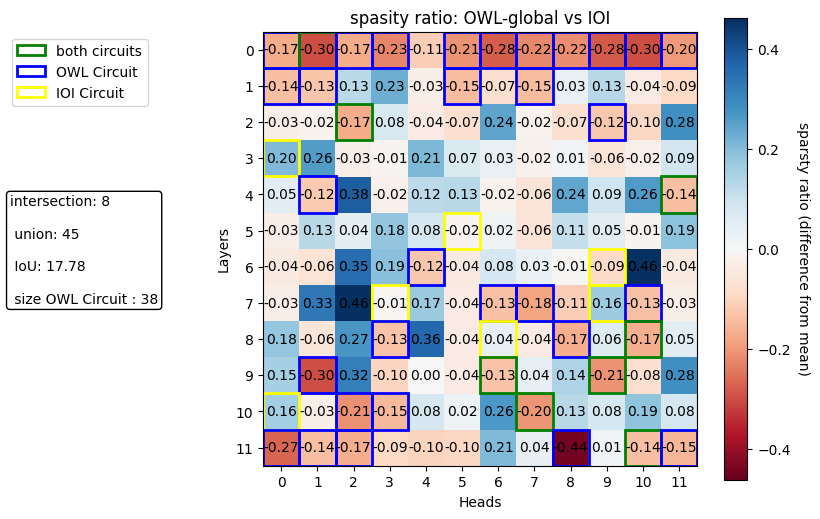

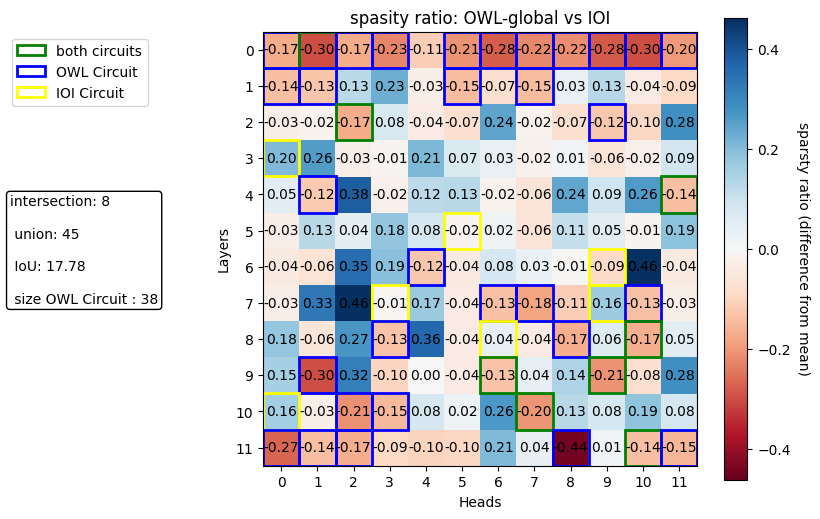

In [72]:
#from OWL.lib.prune_all_hooked import sublayer_statistics, sparsity_ratio
from utils.Visualization import heat_map_sparsity

W_O = hooked_model.W_O
sparsities =  np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))

for layer in range(hooked_model.cfg.n_layers):
    head_sparisty = []
    for head in range(hooked_model.cfg.n_heads):
        head_sparsity_ratio = sparsity_ratio(W_O[layer][head],value=0)
        head_sparisty.append(head_sparsity_ratio)
    sparsities[layer] = head_sparisty
#best scaler=0.38

scaler=0.75 #-> high intersection on the late layers!
#scaler=9  #for hoook_input_q

W_O_total_mean = np.mean(sparsities)
W_O_total_std = np.std(head_sparisty)
print("std", W_O_total_std)

CIRCUIT_PRUNING_GLOBAL = {}
for layer in range(hooked_model.cfg.n_layers):
    CIRCUIT_PRUNING_GLOBAL[layer] = []
    for head_idx in range(hooked_model.cfg.n_heads):
        # if indicidual head has more weights pruned than the total mean, the difference will be negative and the head immediatelly pruned
        # a head is only in the circuit, if it prunes (significantly) less weights than average 
        # (#pruned_weights_in_head) << (average_pruned_weights_in_model)
        
        diff_from_mean =  W_O_total_mean  - sparsities[layer, head_idx]

        if diff_from_mean >= scaler * W_O_total_std:
            CIRCUIT_PRUNING_GLOBAL[layer].append(head_idx)
# print("CIRCUIT PRUNING", CIRCUIT_PRUNING_GLOBAL)

sparsties_diff = sparsities - W_O_total_mean
heat_map_sparsity(sparsties_diff, IOI_CIRCUIT,CIRCUIT_PRUNING_GLOBAL, title="spasity ratio: OWL-global vs IOI")
            

In [73]:
## knockout new method, without seq_pos_to_keep dic
model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=CIRCUIT_PRUNING_GLOBAL
)
logits_minimal_global = model_mean_ablation(dataset.clean_tokens)
ave_logit_global = ave_logit_diff(logits_minimal_global,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))

print(f"Average logit difference (IOI dataset, OWL-global: {ave_logit_global:.4f}" )
print(f"circuit size", circuit_size(CIRCUIT_PRUNING_GLOBAL))
print(f"performance achieved {performance_achieved(ave_logit_gt, ave_logit_global):.2f}%")
print(f"IoU of IOI and CIRCUIT_GLOBAL  {IoU_nodes(IOI_CIRCUIT, CIRCUIT_PRUNING_GLOBAL)*100:.2f}% \n")

Average logit difference (IOI dataset, OWL-global: -0.3188
circuit size 38
performance achieved -8.02%
IoU of IOI and CIRCUIT_GLOBAL  17.78% 



#### after running OWL, prune locally:

total std 0.15247329711529384
CIRCUIT PRUNING {0: [], 1: [], 2: [2], 3: [], 4: [1, 11], 5: [], 6: [4], 7: [6, 7, 10], 8: [3, 8, 10], 9: [1, 9], 10: [2, 3, 7], 11: [0, 8]}


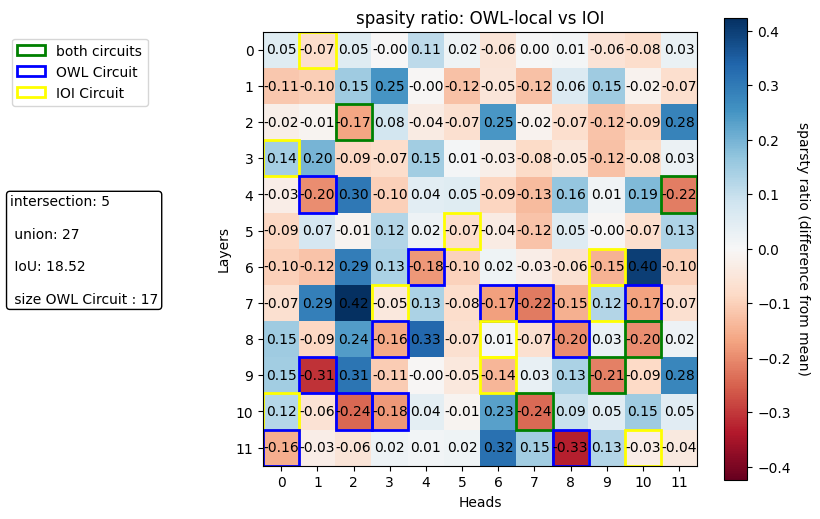

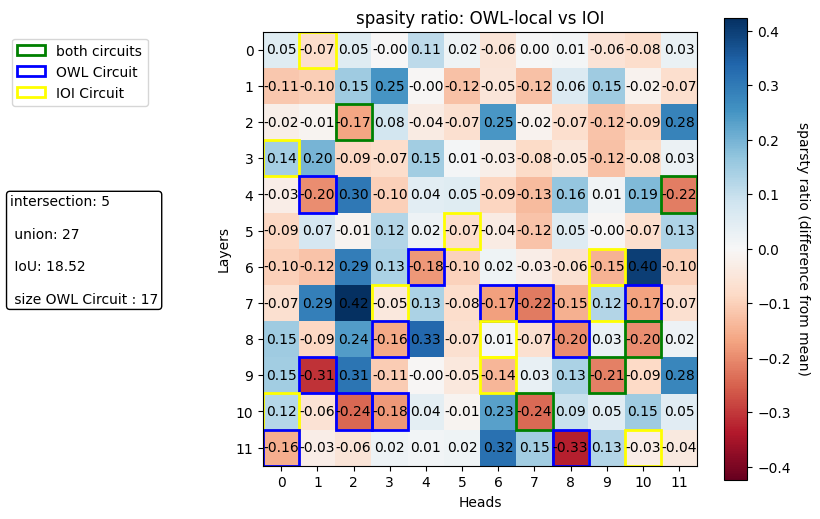

In [78]:
from utils.Visualization import heat_map_sparsity


W_O = hooked_model.W_O
sparsities =  np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))
sparsties_diff = np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))

for layer in range(hooked_model.cfg.n_layers):
    head_sparisty = []
    for head in range(hooked_model.cfg.n_heads):
        head_sparsity_ratio = sparsity_ratio(W_O[layer][head],value=0.0)
        head_sparisty.append(head_sparsity_ratio)
    sparsities[layer] = head_sparisty


#scaler=10 #-> hook_q_input
scaler=1
#scaler=0.5 #-> hook_q_input


total_std = np.std(head_sparisty)

CIRCUIT_PRUNING_LOCAL = {}
for layer in range(hooked_model.cfg.n_layers):
    CIRCUIT_PRUNING_LOCAL[layer] = []
    for head_idx in range(hooked_model.cfg.n_heads):
        
        diff_from_mean =  np.mean(sparsities[layer]) - sparsities[layer, head_idx]
        sparsties_diff[layer, head_idx] = -diff_from_mean

        if  diff_from_mean >= scaler * total_std:
            CIRCUIT_PRUNING_LOCAL[layer].append(head_idx)
            
print("total std", scaler * total_std)            

print("CIRCUIT PRUNING", CIRCUIT_PRUNING_LOCAL)
heat_map_sparsity(sparsties_diff, IOI_CIRCUIT,CIRCUIT_PRUNING_LOCAL, title="spasity ratio: OWL-local vs IOI")

Average logit difference (IOI dataset, OWL-local): 0.9276
circuit size 27
performance achieved 30.60%
intersection 10
union 32
IoU of IOI and CIRCUIT_LOCAL 31.25% 

intersection 10
union 32


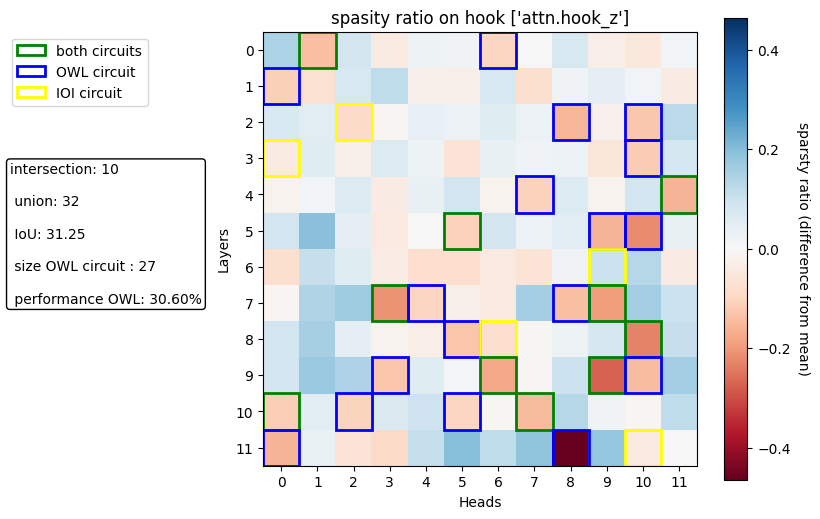

In [175]:
## knockout new method, without seq_pos_to_keep dic
model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=CIRCUIT_PRUNING_LOCAL
)
logits_minimal_local = model_mean_ablation(dataset.clean_tokens)
ave_logit_local = ave_logit_diff(logits_minimal_local,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))
performance_local=performance_achieved(ave_logit_gt, ave_logit_local)

print(f"Average logit difference (IOI dataset, OWL-local): {ave_logit_local:.4f}")
print(f"circuit size", circuit_size(CIRCUIT_PRUNING_LOCAL))
print(f"performance achieved {performance_local:.2f}%")
print(f"IoU of IOI and CIRCUIT_LOCAL {IoU_nodes(IOI_CIRCUIT, CIRCUIT_PRUNING_LOCAL)*100:.2f}% \n")


heat_map_sparsity(
    sparsties_diff, 
    IOI_CIRCUIT,
    #IOI_CIRCUIT_BACKUP_HEADS,
    CIRCUIT_PRUNING_LOCAL, 
    title=f"spasity ratio on hook {args.target_layers}",
    performance=performance_local)

In [162]:
from utils import difference_circuits, intersect_circuits
## Performance of Intersection with IOI circuit alone
INTERSECTION = intersect_circuits(IOI_CIRCUIT, CIRCUIT_PRUNING_LOCAL)
print("intersection circuit", INTERSECTION)
model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=INTERSECTION
)
logits_intersection = model_mean_ablation(dataset.clean_tokens)
ave_intersection = ave_logit_diff(logits_intersection,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))
performance_intersection=performance_achieved(ave_logit_gt, ave_intersection)

print(f"Average logit difference (IOI dataset, INTERSECTION): {ave_intersection:.4f}")
print(f"circuit size", circuit_size(INTERSECTION))
print(f"performance achieved {performance_intersection:.2f}%")
print(f"IoU of IOI and INTERSECTION {IoU_nodes(IOI_CIRCUIT, INTERSECTION)*100:.2f}% \n")


## Performance of OWL circuit not intersecting with IOI circuit
DIFFERNCE = difference_circuits(CIRCUIT_PRUNING_LOCAL, IOI_CIRCUIT)
print("difference circuit", DIFFERNCE)
model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=DIFFERNCE
)
logits_difference = model_mean_ablation(dataset.clean_tokens)
ave_differecne = ave_logit_diff(logits_difference,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))
performance_difference =performance_achieved(ave_logit_gt, ave_differecne)

print(f"Average logit difference (IOI dataset, DIFFERNCE): {ave_differecne:.4f}")
print(f"circuit size", circuit_size(DIFFERNCE))
print(f"performance achieved {performance_difference:.2f}%")
print(f"IoU of IOI and DIFFERNCE {IoU_nodes(IOI_CIRCUIT, DIFFERNCE)*100:.2f}% \n")




intersection circuit {0: set(), 1: set(), 2: set(), 3: set(), 4: {11}, 5: set(), 6: set(), 7: {9, 3}, 8: {10}, 9: {9, 6}, 10: {7}, 11: set()}
Average logit difference (IOI dataset, INTERSECTION): 0.6699
circuit size 7
performance achieved 22.10%
intersection 7
union 15
IoU of IOI and INTERSECTION 46.67% 

difference circuit {0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: {10}, 6: set(), 7: {8}, 8: set(), 9: set(), 10: set(), 11: {8}}
Average logit difference (IOI dataset, DIFFERNCE): 0.4198
circuit size 3
performance achieved 13.85%
intersection 0
union 18
IoU of IOI and DIFFERNCE 0.00% 



### GLOBAL prune z-, q-, k- hook

loading llm model gpt2


/mnt/qb/work/eickhoff/esx670/.conda/py-311-pytorch/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
Moving model to device:  cpu
using different length!
std 0.0
CIRCUIT PRUNING {0: [], 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}
intersection 2
union 49


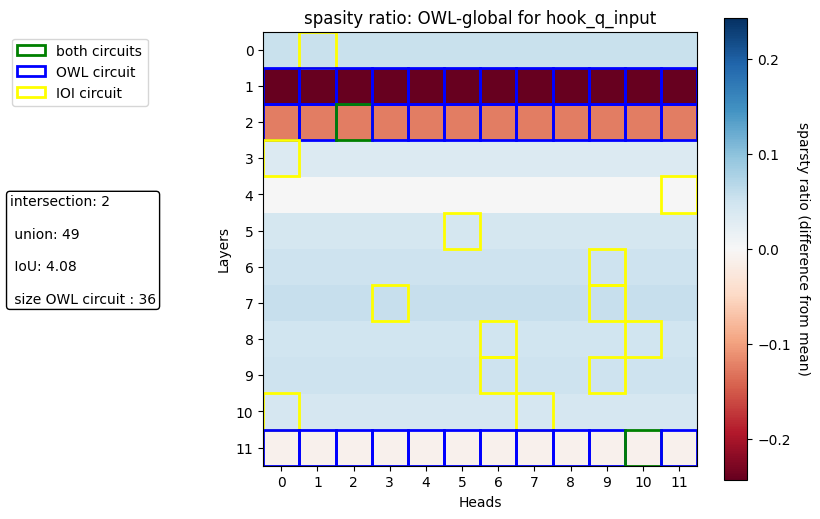

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
Moving model to device:  cpu
using different length!
std 0.0
CIRCUIT PRUNING {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}
intersection 3
union 60


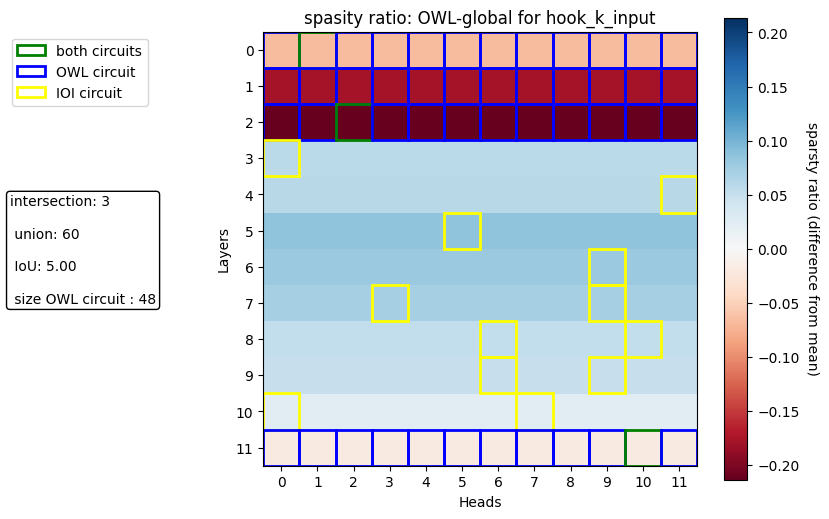

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
Moving model to device:  cpu
using different length!
std 1.1102230246251565e-16
CIRCUIT PRUNING {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 11: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}
intersection 6
union 81


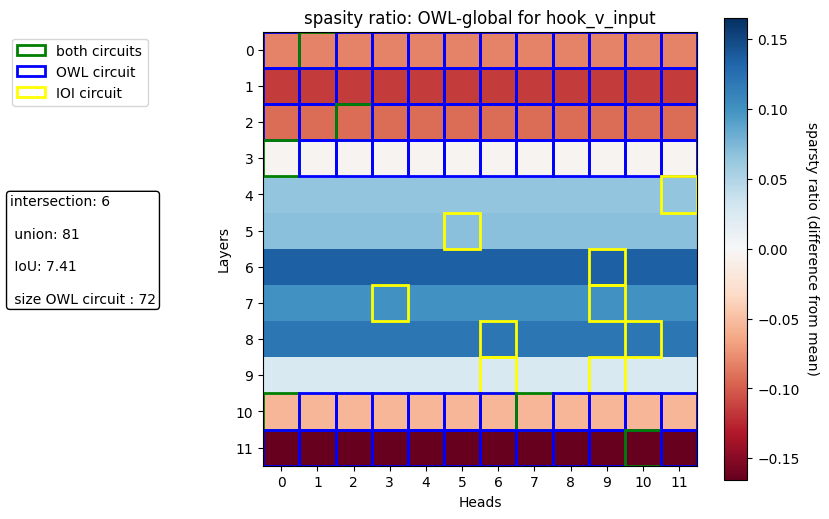

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
Moving model to device:  cpu
using different length!
std 0.1726207305367338
CIRCUIT PRUNING {0: [1, 3, 4, 5, 6, 7, 9, 10, 11], 1: [], 2: [8], 3: [], 4: [], 5: [10], 6: [], 7: [], 8: [10], 9: [6, 9], 10: [], 11: [0, 8]}
intersection 4
union 27


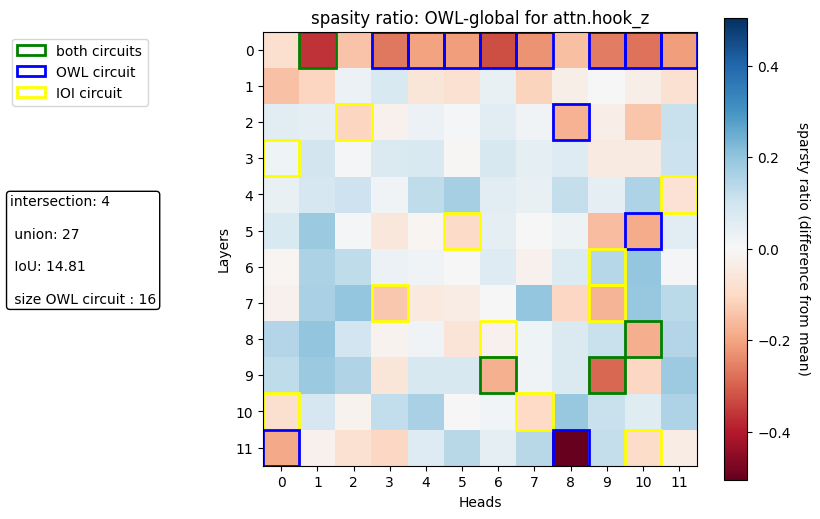

In [176]:
from OWL.lib.prune_all_hooked import sublayer_statistics, sparsity_ratio
from OWL.lib.visual import heat_map_sparsity
from utils import merge_circuits

torch.cuda.empty_cache()

model_name = args.model.split("/")[-1]
print(f"loading llm model {args.model}")

CIRCUIT_PRUNING_GLOBAL = {}

all_sparsities = []

hooks = ["hook_q_input", "hook_k_input", "hook_v_input", "attn.hook_z"]
#hooks = ["hook_q_input", "hook_k_input",  "attn.hook_z"]
#hooks = ["hook_q_input","attn.hook_z"]
for target in hooks:

    args.target_layers = [target]
    hooked_model = get_hooked_llm(args.model, device)
    hooked_model.eval()
    hooked_model.training=False
    hooked_model.to(device)

    OWL_corrupted_activ_pruning(
        args, 
        None, 
        hooked_model, 
        hooked_tokenizer, 
        device, 
        prune_n=prune_n, 
        prune_m=prune_m, 
        dataset_name=args.dataset_name,
        corrupt_knockout=False, 
        testing=False,
        per_sublayer=False,
        test_inps=None,
        head_pruning=False,
        head_pruning_by_score=False,
        scaler=0.78
        )
    
    if target == "hook_q_input" : 
        W = hooked_model.W_Q
        scaler=8

    elif target == "hook_k_input":
        W = hooked_model.W_K
        scaler=8
        
    elif target == "hook_v_input":
        W = hooked_model.W_V
        scaler=3
        
    elif target == "attn.hook_z":
        W = hooked_model.W_O
        scaler = 1
        
    sparsities =  np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))
    for layer in range(hooked_model.cfg.n_layers):
        head_sparisty = []
        for head in range(hooked_model.cfg.n_heads):
            head_sparsity_ratio = sparsity_ratio(W [layer][head],value=0)
            head_sparisty.append(head_sparsity_ratio)
        sparsities[layer] = head_sparisty
    
    all_sparsities.append(sparsities)
    
    # best scaler=0.38
    #scaler=1.25 -> high intersection on the late layers!

    total_mean = np.mean(sparsities)
    total_std = np.std(head_sparisty)
    print("std", total_std)

    CIRCUIT_HOOK = {}
    for layer in range(hooked_model.cfg.n_layers):
        CIRCUIT_HOOK[layer] = []
        for head_idx in range(hooked_model.cfg.n_heads):
            # if indicidual head has more weights pruned than the total mean, the difference will be negative and the head immediatelly pruned
            # a head is only in the circuit, if it prunes (significantly) less weights than average 
            # (#pruned_weights_in_head) << (average_pruned_weights_in_model)
            
            diff_from_mean =  total_mean  - sparsities[layer, head_idx]

            if diff_from_mean >= scaler * total_std:
                CIRCUIT_HOOK[layer].append(head_idx)
    print("CIRCUIT PRUNING", CIRCUIT_HOOK)

    sparsties_diff = sparsities - total_mean
    heat_map_sparsity(sparsties_diff, IOI_CIRCUIT, CIRCUIT_HOOK, title=f"spasity ratio: OWL-global for {target}")
    
    CIRCUIT_PRUNING_GLOBAL = merge_circuits(CIRCUIT_PRUNING_GLOBAL, CIRCUIT_HOOK)
    

In [ ]:
## knockout new method, without seq_pos_to_keep dic
model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=CIRCUIT_PRUNING_GLOBAL
)
logits_minimal_global = model_mean_ablation(dataset.clean_tokens)
ave_logit_global = ave_logit_diff(logits_minimal_global,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))

print(f"Average logit difference (IOI dataset, OWL-global: {ave_logit_global:.4f}" )
print(f"circuit size", circuit_size(CIRCUIT_PRUNING_GLOBAL))
print(f"performance achieved {performance_achieved(ave_logit_gt, ave_logit_global):.2f}%")
print(f"IoU of IOI and CIRCUIT_GLOBAL  {IoU_nodes(IOI_CIRCUIT, CIRCUIT_PRUNING_GLOBAL)*100:.2f}% \n")

Average logit difference (IOI dataset, OWL-global: -0.0728
circuit size 18
performance achieved -2.40%
intersection 8
union 25
IoU of IOI and CIRCUIT_GLOBAL  32.00% 



In [ ]:
if  type(all_sparsities) == list:
    all_sparsities = np.array(all_sparsities)
    all_sparsities=np.mean(all_sparsities, axis=0)
    print(all_sparsities.shape)


scaler=0.8
total_std = np.std(all_sparsities)
sparsties_diff = np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))

CIRCUIT_HOOK = {}
for layer in range(hooked_model.cfg.n_layers):
    CIRCUIT_HOOK[layer] = []
    for head_idx in range(hooked_model.cfg.n_heads):
      
        diff_from_mean =  np.mean(all_sparsities[layer]) - all_sparsities[layer, head_idx]

        if  diff_from_mean >= scaler * total_std:
            CIRCUIT_HOOK[layer].append(head_idx)
        sparsties_diff[layer, head_idx] = -diff_from_mean
            

Average logit difference (IOI dataset mean over hooks): 1.6972
circuit size 29
performance achieved 56.00%
intersection 13
union 31
IoU of IOI and CIRCUIT_GLOBAL  41.94% 

intersection 13
union 31


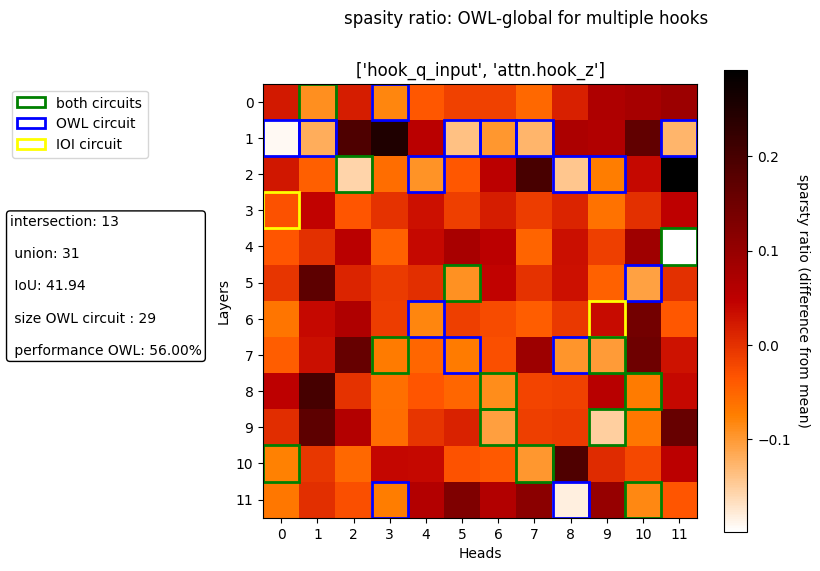

In [ ]:
## knockout new method, without seq_pos_to_keep dic
model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=CIRCUIT_HOOK
)
logits_minimal_hooks = model_mean_ablation(dataset.clean_tokens)
ave_logit_hooks = ave_logit_diff(logits_minimal_hooks,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))
performance_hooks = performance_achieved(ave_logit_gt, ave_logit_hooks)

print(f"Average logit difference (IOI dataset mean over hooks): {ave_logit_hooks:.4f}" )
print(f"circuit size", circuit_size(CIRCUIT_HOOK))
print(f"performance achieved {performance_hooks:.2f}%")
print(f"IoU of IOI and CIRCUIT_GLOBAL  {IoU_nodes(IOI_CIRCUIT, CIRCUIT_HOOK)*100:.2f}% \n")


heat_map_sparsity(
    sparsties_diff, 
    IOI_CIRCUIT, 
    CIRCUIT_HOOK, 
    title=f"spasity ratio: OWL-global for multiple hooks", 
    performance = performance_hooks,
    subtitle=["hook_q_input","attn.hook_z"])

### LOCAL multiple hook pruning

loading llm model gpt2


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
Moving model to device:  cpu


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
using different length!
using different length!
std 0.016051607522608476
CIRCUIT PRUNING {0: [3], 1: [0, 6], 2: [2, 4], 3: [], 4: [11], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: []}
intersection 2
union 19


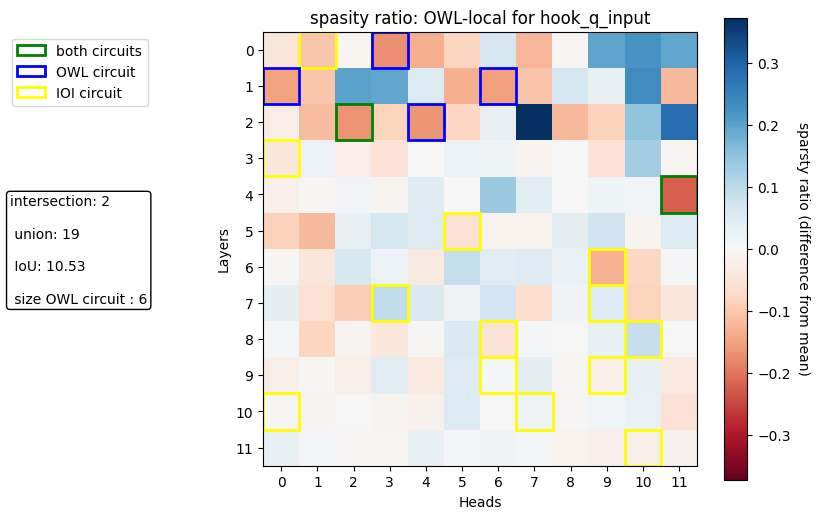

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
using different length!
using different length!
std 0.015857515850178687
CIRCUIT PRUNING {0: [5], 1: [0, 6], 2: [], 3: [], 4: [11], 5: [1], 6: [9], 7: [], 8: [], 9: [], 10: [], 11: []}
intersection 2
union 19


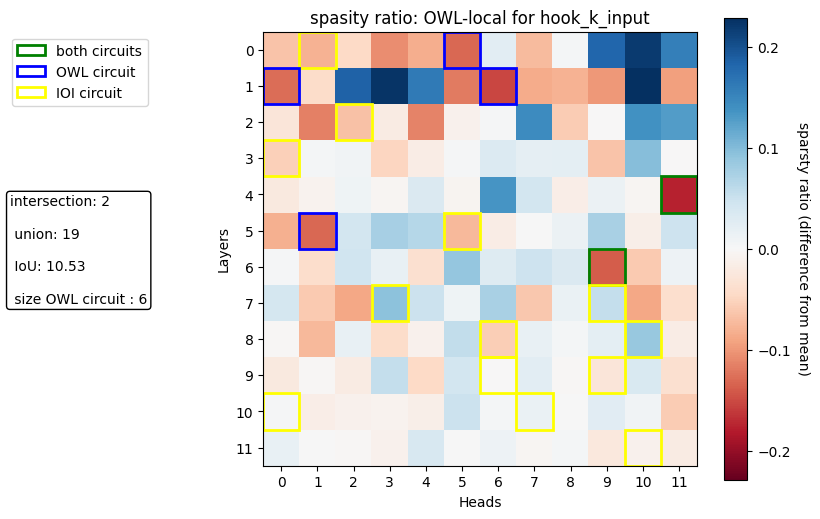

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
using different length!
using different length!
std 0.16624139108268368
CIRCUIT PRUNING {0: [], 1: [], 2: [], 3: [], 4: [11], 5: [10], 6: [], 7: [3, 8, 9], 8: [10], 9: [6, 9, 10], 10: [0, 7], 11: [8]}
intersection 8
union 19


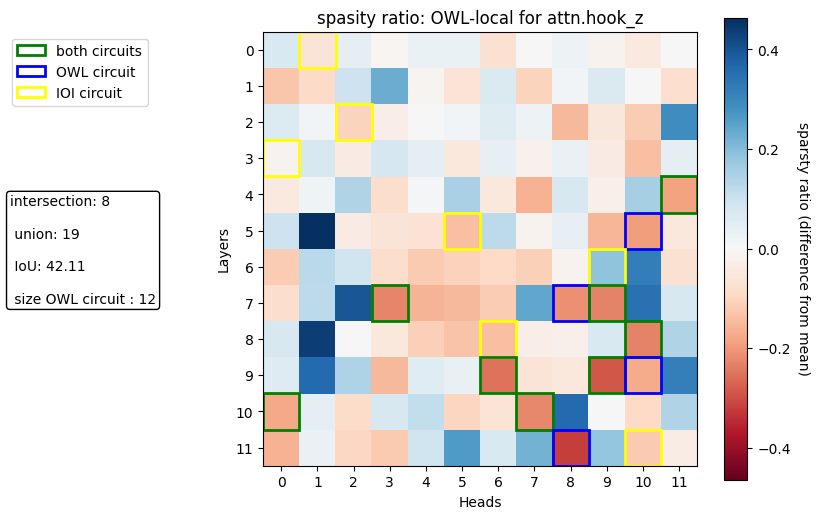

In [61]:
from OWL.lib.prune_all_hooked import sublayer_statistics, sparsity_ratio
from OWL.lib.visual import heat_map_sparsity
from utils import merge_circuits

torch.cuda.empty_cache()

model_name = args.model.split("/")[-1]
print(f"loading llm model {args.model}")

CIRCUIT_PRUNING_LOCAL = {}
args.verbose=False
all_sparsities = []

#hooks = ["hook_q_input", "hook_k_input", "hook_v_input", "attn.hook_z"]
hooks = ["hook_q_input", "hook_k_input",  "attn.hook_z"]
#hooks = ["hook_q_input","attn.hook_z"]
#for target in hooks:

hooked_model = get_hooked_llm(args.model, device)
hooked_model.eval()
hooked_model.training=False
hooked_model.to(device)

    
args.seed= 6700098

for target in hooks:
    hooked_model = get_hooked_llm(args.model, device)
    args.target_layers=[target]
    OWL_corrupted_activ_pruning(
        args, 
        None, 
        hooked_model, 
        hooked_tokenizer, 
        device, 
        prune_n=prune_n, 
        prune_m=prune_m, 
        dataset_name=args.dataset_name,
        corrupt_knockout=True, 
        testing=False,
        per_sublayer=False,
        test_inps=None,
        head_pruning=False,
        head_pruning_by_score=False,
        scaler=0.78
        )

    if target == "hook_q_input" : 
        W = hooked_model.W_Q
        scaler=9

    elif target == "hook_k_input":
        W = hooked_model.W_K
        scaler=8
        
    elif target == "hook_v_input":
        W = hooked_model.W_V
        scaler=3
        
    elif target == "attn.hook_z":
        W = hooked_model.W_O
        scaler = 1
        
    sparsities =  np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))
    for layer in range(hooked_model.cfg.n_layers):
        head_sparisty = []
        for head in range(hooked_model.cfg.n_heads):
            head_sparsity_ratio = sparsity_ratio(W [layer][head],value=0)
            head_sparisty.append(head_sparsity_ratio)
        sparsities[layer] = head_sparisty

    all_sparsities.append(sparsities)

    # best scaler=0.38
    #scaler=1.25 -> high intersection on the late layers!

    total_std = np.std(head_sparisty)
    print("std", total_std)

    CIRCUIT_HOOK_LOCAL = {}
    for layer in range(hooked_model.cfg.n_layers):
        CIRCUIT_HOOK_LOCAL[layer] = []
        for head_idx in range(hooked_model.cfg.n_heads):
            # if indicidual head has more weights pruned than the total mean, the difference will be negative and the head immediatelly pruned
            # a head is only in the circuit, if it prunes (significantly) less weights than average 
            # (#pruned_weights_in_head) << (average_pruned_weights_in_model)
            
            diff_from_mean =  np.mean(sparsities[layer])  - sparsities[layer, head_idx]
            sparsties_diff[layer, head_idx] = -diff_from_mean
            if diff_from_mean >= scaler * total_std:
                CIRCUIT_HOOK_LOCAL[layer].append(head_idx)
    print("CIRCUIT PRUNING", CIRCUIT_HOOK_LOCAL)

    heat_map_sparsity(sparsties_diff, IOI_CIRCUIT, CIRCUIT_HOOK_LOCAL, title=f"spasity ratio: OWL-local for {target}")

    CIRCUIT_PRUNING_LOCAL = merge_circuits(CIRCUIT_PRUNING_LOCAL, CIRCUIT_HOOK_LOCAL)


Average logit difference (IOI dataset, OWL-global: 0.4291
circuit size 20
performance achieved 14.16%
intersection 10
union 25
IoU of IOI and CIRCUIT_GLOBAL  40.00% 

intersection 10
union 25


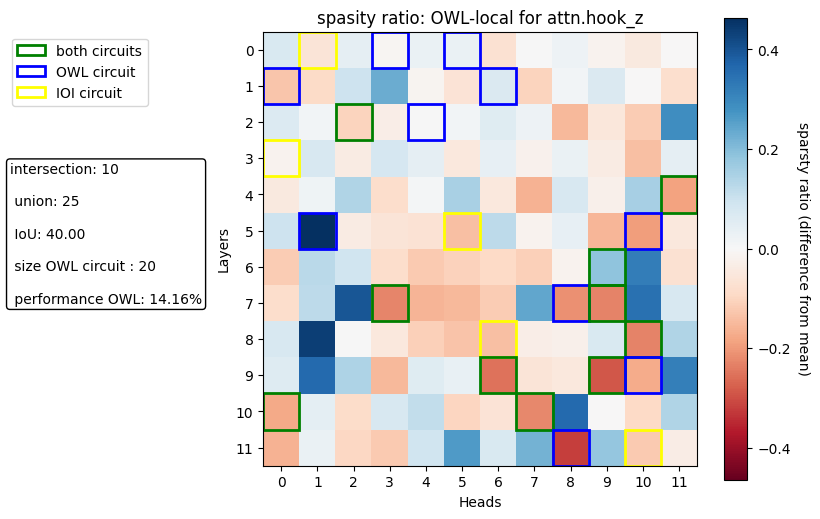

In [62]:
## knockout new method, without seq_pos_to_keep dic
model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=CIRCUIT_PRUNING_LOCAL
)
logits_minimal_local = model_mean_ablation(dataset.clean_tokens)
ave_logit_local = ave_logit_diff(logits_minimal_local,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))
performance_local = performance_achieved(ave_logit_gt, ave_logit_local)

print(f"Average logit difference (IOI dataset, OWL-global: {ave_logit_local:.4f}" )
print(f"circuit size", circuit_size(CIRCUIT_PRUNING_LOCAL))
print(f"performance achieved {performance_local:.2f}%")
print(f"IoU of IOI and CIRCUIT_GLOBAL  {IoU_nodes(IOI_CIRCUIT, CIRCUIT_PRUNING_LOCAL)*100:.2f}% \n")


heat_map_sparsity(sparsties_diff, IOI_CIRCUIT, CIRCUIT_PRUNING_LOCAL, title=f"spasity ratio: OWL-local for {target}", performance =performance_local)


intersection 11
union 41


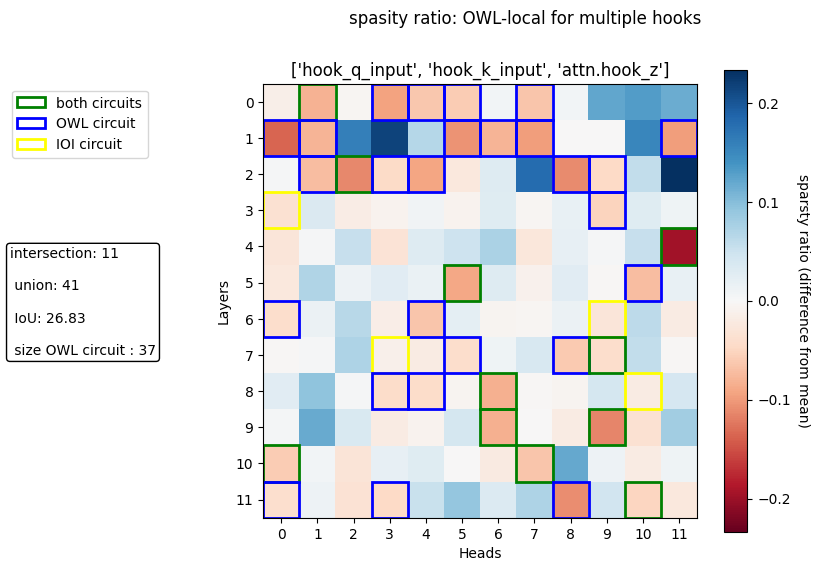

In [66]:
if  type(all_sparsities) == list:
    all_sparsities = np.array(all_sparsities)
    all_sparsities=np.mean(all_sparsities, axis=0)
    print(all_sparsities.shape)


scaler=0.4
total_std = np.std(all_sparsities)
sparsties_diff = np.zeros((hooked_model.cfg.n_layers, hooked_model.cfg.n_heads))

CIRCUIT_HOOK = {}
for layer in range(hooked_model.cfg.n_layers):
    CIRCUIT_HOOK[layer] = []
    for head_idx in range(hooked_model.cfg.n_heads):
      
        diff_from_mean =  np.mean(all_sparsities[layer]) - all_sparsities[layer, head_idx]

        if  diff_from_mean >= scaler * total_std:
            CIRCUIT_HOOK[layer].append(head_idx)
        sparsties_diff[layer, head_idx] = -diff_from_mean
        

heat_map_sparsity(
    sparsties_diff, 
    IOI_CIRCUIT, 
    CIRCUIT_HOOK, 
    title=f"spasity ratio: OWL-local for multiple hooks", 
    subtitle=hooks)

            

Average logit difference (IOI dataset mean over hooks): 1.0884
circuit size 37
performance achieved 35.91%
intersection 11
union 41
IoU of IOI and CIRCUIT_GLOBAL  26.83% 

intersection 11
union 41


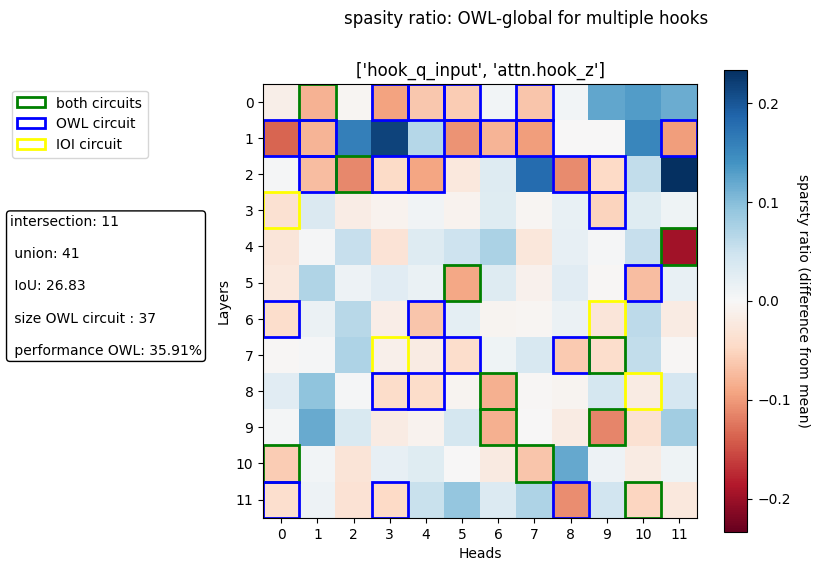

In [67]:
## knockout new method, without seq_pos_to_keep dic
model_mean_ablation = add_mean_ablation_hook(
    model=model_mean_ablation, 
    means_dataset=dataset.corrupted_dataset,
    circuit=CIRCUIT_HOOK
)
logits_minimal_hooks = model_mean_ablation(dataset.clean_tokens)
ave_logit_hooks = ave_logit_diff(logits_minimal_hooks,  dataset.answer_tokens.to(device), dataset.target_idx.to(device))
performance_hooks = performance_achieved(ave_logit_gt, ave_logit_hooks)

print(f"Average logit difference (IOI dataset mean over hooks): {ave_logit_hooks:.4f}" )
print(f"circuit size", circuit_size(CIRCUIT_HOOK))
print(f"performance achieved {performance_hooks:.2f}%")
print(f"IoU of IOI and CIRCUIT_GLOBAL  {IoU_nodes(IOI_CIRCUIT, CIRCUIT_HOOK)*100:.2f}% \n")


heat_map_sparsity(
    sparsties_diff, 
    IOI_CIRCUIT, 
    CIRCUIT_HOOK, 
    title=f"spasity ratio: OWL-global for multiple hooks", 
    performance = performance_hooks,
    subtitle=["hook_q_input","attn.hook_z"])

## Summary

In [ ]:
from OWL.lib.eval import IoU_nodes


print(f"Average logit difference (IOI dataset, entire model): {ave_logit_gt:.4f} \n ")
print(f"Average logit difference (IOI dataset, test circuit -- adapted): {ave_logit_test:.4f}")
print(f"circuit size", circuit_size(TEST_CIRCUIT))
print(f"performance achieved {performance_achieved(ave_logit_gt, ave_logit_test):.2f}% \n")

print(f"Average logit difference (IOI dataset, OWL -- adapted): {ave_logit_OWL:.4f}")
print(f"performance achieved {performance_achieved(ave_logit_gt, ave_logit_OWL):.2f}% \n")



print(f"Average logit difference (IOI dataset, IOI circuit -- original): {ave_logits_orig:.4f}")
print(f"circuit size", circuit_size(CIRCUIT))
print(f"performance achieved  {performance_achieved(ave_logit_gt, ave_logits_orig):.2f}% \n")


print(f"Average logit difference (IOI dataset, IOI circuit -- adapted): {ave_logits_adapat:.4f}")
print(f"circuit size", circuit_size(IOI_CIRCUIT))
print(f"performance achieved  {performance_achieved(ave_logit_gt, ave_logits_adapat):.2f}% \n")


print(f"Average logit difference (IOI dataset, OWL-global: {ave_logit_global:.4f}" )
print(f"circuit size", circuit_size(CIRCUIT_PRUNING_GLOBAL))
print(f"performance achieved {performance_achieved(ave_logit_gt, ave_logit_global):.2f}%")
print(f"IoU of IOI and CIRCUIT_GLOBAL  {IoU_nodes(IOI_CIRCUIT, CIRCUIT_PRUNING_GLOBAL)*100:.2f}% \n")


print(f"Average logit difference (IOI dataset, OWL-local): {ave_logit_local:.4f}")
print(f"circuit size", circuit_size(CIRCUIT_PRUNING_LOCAL))
print(f"performance achieved {performance_achieved(ave_logit_gt, ave_logit_local):.2f}%")
print(f"IoU of IOI and CIRCUIT_LOCAL {IoU_nodes(IOI_CIRCUIT, CIRCUIT_PRUNING_LOCAL)*100:.2f}% \n")



Average logit difference (IOI dataset, entire model): 3.0309 
 
Average logit difference (IOI dataset, test circuit -- adapted): 3.0384
circuit size 143
performance achieved 100.25% 



NameError: name 'ave_logit_OWL' is not defined

### IoU per Layer

In [ ]:
from OWL.lib.eval import *

def IntersectionPerLayer(circuit1, circuit2):

    for layer in range(hooked_model.cfg.n_layers):
        heads1 = set(circuit1.get(layer, []))
        heads2 = set(circuit2.get(layer, []))

        intersection = len(heads1 & heads2)
        union = len(heads1 | heads2)

        print("layer", layer, "IoU", intersection/union)
            

IntersectionPerLayer(IOI_CIRCUIT, CIRCUIT_PRUNING_GLOBAL)

layer 0 IoU 0.3333333333333333
layer 1 IoU 0.0
layer 2 IoU 0.3333333333333333
layer 3 IoU 0.0
layer 4 IoU 0.5
layer 5 IoU 0.5
layer 6 IoU 0.0
layer 7 IoU 0.6666666666666666
layer 8 IoU 0.3333333333333333
layer 9 IoU 0.3333333333333333
layer 10 IoU 0.42857142857142855
layer 11 IoU 0.0


## Evaluate

### Linegraph with Dual Y-Axis

DataFrame saved as 1178778.csv at /mnt/qb/home/eickhoff/esx670/OverlapMetric/res/OWL
['circuit_type', 'Hyper_m', 'sparsity_ratio', 'Lambda', 'scaler', 'size', 'ave logit diff', 'performance', 'IoU']


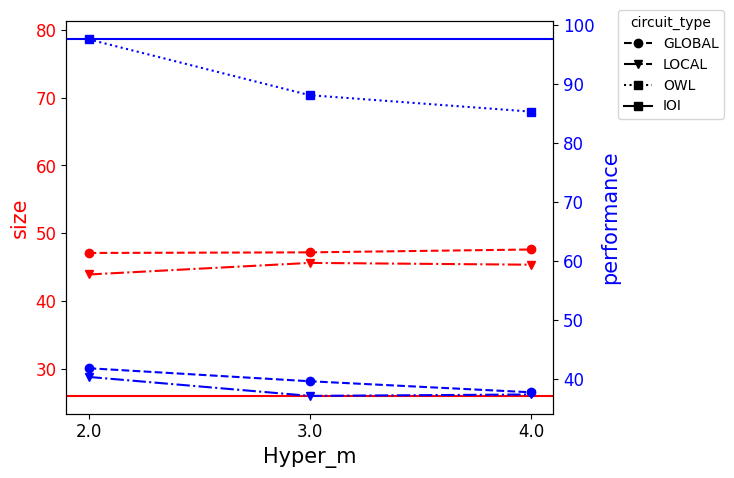

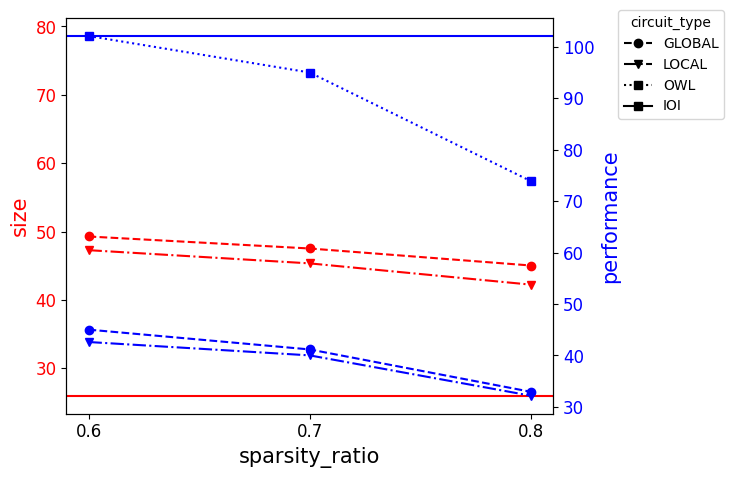

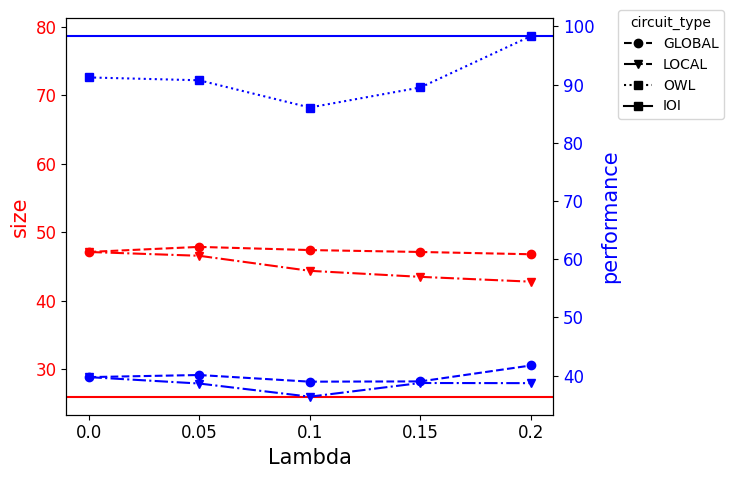

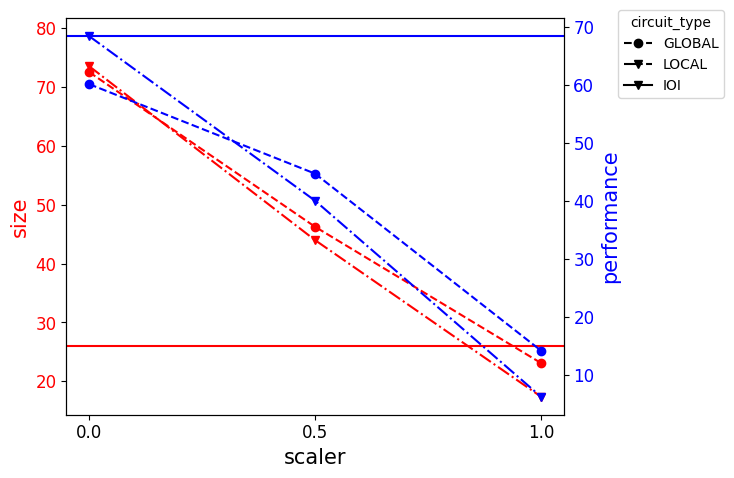

In [ ]:
from utils import read_df, save_img
from OWL.lib.visual import line_graph, all_figs_from_df
name="1178778"
df = read_df(in_path="/mnt/qb/home/eickhoff/esx670/OverlapMetric/res/OWL", name=name+".csv")
print(list(df.columns.values))
groups = list(df.columns.values)

label_group = [groups[0]]
x_group = groups[1:5]
y_group = ["size", "performance"]

all_figs_from_df(df, name=name, x_group=x_group, y_group=y_group, label_group=label_group)

DataFrame saved as 1178778.csv at /mnt/qb/home/eickhoff/esx670/OverlapMetric/res/OWL
['circuit_type', 'Hyper_m', 'sparsity_ratio', 'Lambda', 'scaler', 'size', 'ave logit diff', 'performance', 'IoU']


/mnt/qb/home/eickhoff/esx670/OverlapMetric/OWL/lib/visual.py:90: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_agg = df.groupby([group_name, x_name]).mean().reset_index()
/mnt/qb/home/eickhoff/esx670/OverlapMetric/OWL/lib/visual.py:90: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_agg = df.groupby([group_name, x_name]).mean().reset_index()
/mnt/qb/home/eickhoff/esx670/OverlapMetric/OWL/lib/visual.py:90: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns whic

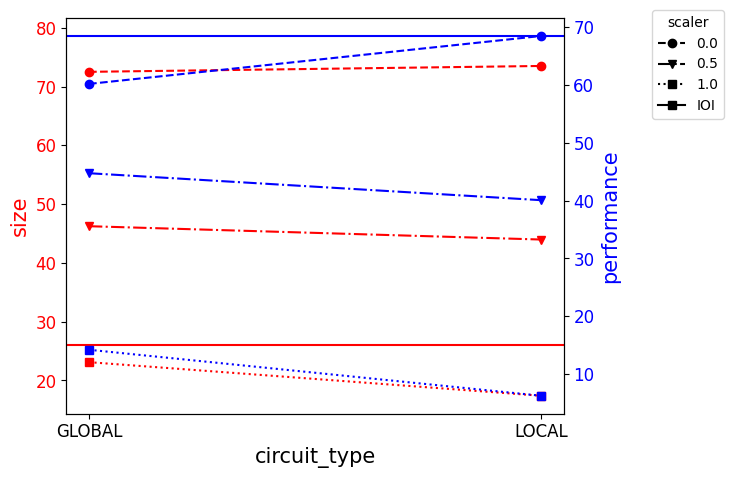

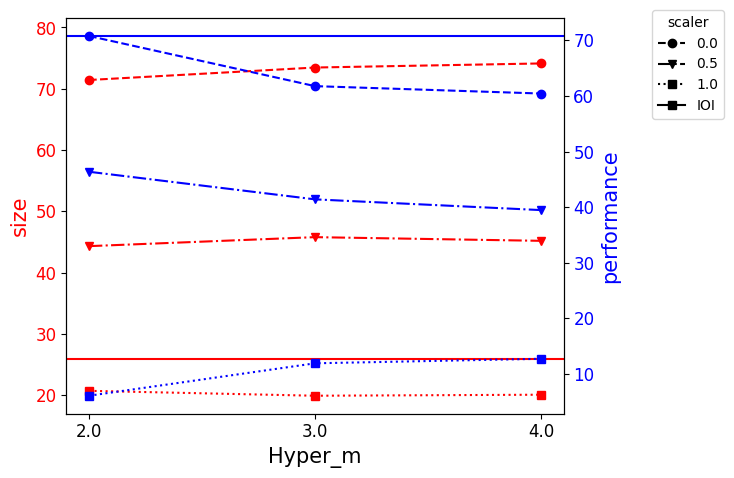

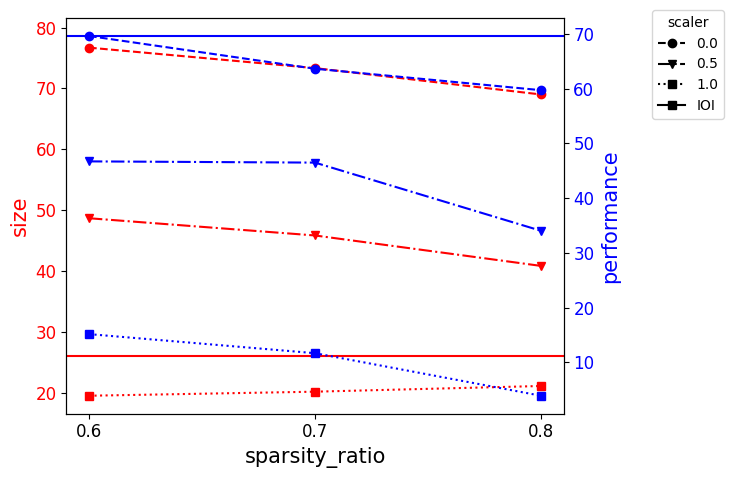

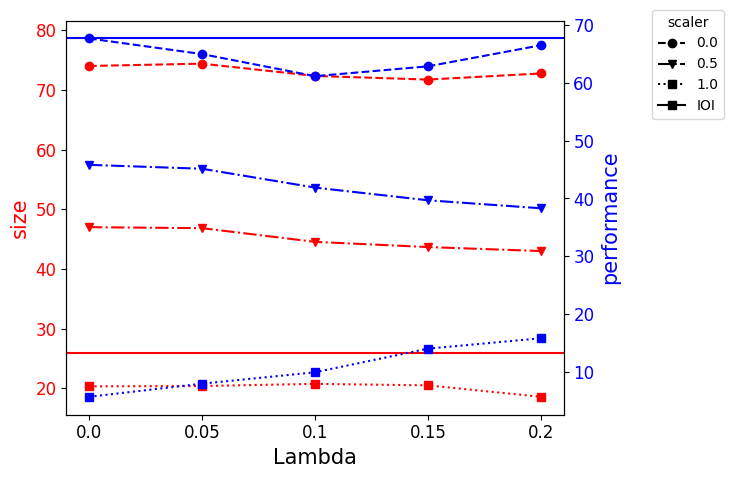

In [ ]:
from utils import read_df, save_img
from OWL.lib.visual import line_graph, all_figs_from_df
name="1178778"
df = read_df(in_path="/mnt/qb/home/eickhoff/esx670/OverlapMetric/res/OWL", name=name+".csv")
print(list(df.columns.values))
groups = list(df.columns.values)

label_group = ["scaler"]
x_group = groups[0:4]
y_group = ["size", "performance"]

all_figs_from_df(df, name=name, x_group=x_group, y_group=y_group, label_group=label_group)

### get Max values

In [ ]:
from OWL.lib.visual import get_max_row_per_group, get_min_row_per_group


groups = list(df.columns.values)

df_reduced = df[df["circuit_type"].isin(["GLOBAL", "LOCAL"])]

x_group = groups[0:5]
y_group = ["performance"]

max_df = get_max_row_per_group(df_reduced, x_group, y_group)
print("max_df \n", (max_df))

min_df = get_min_row_per_group(df_reduced, x_group, y_val=["size"])
print("min_df \n", min_df)

max_df 
    circuit_type  Hyper_m  sparsity_ratio  Lambda  scaler  size  \
0        GLOBAL      2.0             0.6    0.05     0.0  75.0   
1         LOCAL      2.0             0.6    0.20     0.0  75.0   
2        GLOBAL      3.0             0.6    0.00     0.0  78.0   
3         LOCAL      3.0             0.6    0.00     0.0  78.0   
4         LOCAL      3.0             0.6    0.05     0.0  78.0   
5         LOCAL      4.0             0.6    0.10     0.0  79.0   
6         LOCAL      2.0             0.6    0.20     0.0  75.0   
7         LOCAL      2.0             0.6    0.20     0.0  75.0   
8         LOCAL      2.0             0.7    0.15     0.0  71.0   
9         LOCAL      2.0             0.7    0.20     0.0  71.0   
10       GLOBAL      2.0             0.8    0.05     0.0  69.0   
11       GLOBAL      2.0             0.6    0.00     0.0  78.0   
12        LOCAL      2.0             0.6    0.00     0.0  78.0   
13       GLOBAL      3.0             0.6    0.00     0.0  78.0   
1

### IoU

In [ ]:
from OWL.lib.eval import IoU
import pickle as pkl

subfolder = "/mnt/qb/work/eickhoff/esx670/res/induction/acdc"
print(f"{subfolder}/acdc_circuit_long.pkl")
with open(f"{subfolder}/acdc_circuit_long.pkl", "rb") as input_file:
    data = pkl.load(input_file)
print(data)
#pp.create_graph_from_pkl(data, path= "test")



/mnt/qb/work/eickhoff/esx670/res/induction/acdc/acdc_circuit_long.pkl
                 child_node child_head                parent_node parent_head  \
0  blocks.1.hook_resid_post        [:]  blocks.1.attn.hook_result   [:, :, 7]   
0  blocks.1.hook_resid_post        [:]  blocks.1.attn.hook_result   [:, :, 6]   
0  blocks.1.hook_resid_post        [:]  blocks.1.attn.hook_result   [:, :, 5]   
0  blocks.1.hook_resid_post        [:]    blocks.0.hook_resid_pre         [:]   
0      blocks.1.attn.hook_v  [:, :, 6]      blocks.1.hook_v_input   [:, :, 6]   
0     blocks.1.hook_v_input  [:, :, 6]  blocks.0.attn.hook_result   [:, :, 4]   

   effect_size  
0    -0.668388  
0    -1.594079  
0     1.710419  
0     2.847767  
0    -1.832548  
0    -0.661552  


In [ ]:
from utils import read_df

df = read_df("/mnt/qb/home/eickhoff/esx670/OverlapMetric/res/OWL", name="123.csv")
print(df)

DataFrame saved as 123.csv at /mnt/qb/home/eickhoff/esx670/OverlapMetric/res/OWL
  circuit_type  sparsity_ratio  Lambda  scaler  size  ave logit diff  \
0         NONE             NaN     NaN     NaN   NaN        2.888179   
1          IOI             NaN     NaN     NaN  26.0        2.097414   
2          OWL             0.6     0.0     NaN   NaN        2.678101   
3       GLOBAL             0.6     0.0     0.0  77.0        1.530641   
4        LOCAL             0.6     0.0     0.0  77.0        1.530641   
5       GLOBAL             0.6     0.0     0.5  50.0        1.154193   
6        LOCAL             0.6     0.0     0.5  50.0        1.154193   
7       GLOBAL             0.6     0.0     1.0  21.0        0.237567   
8        LOCAL             0.6     0.0     1.0  21.0        0.237567   

   performance  
0   100.000000  
1    72.620620  
2    92.726265  
3    52.996756  
4    52.996756  
5    39.962659  
6    39.962659  
7     8.225499  
8     8.225499  


### Testing Calculate WANDA metric and Pruning

In [ ]:
from OWL.lib.prune_all_hooked import calculate_WANDA_metric
import einops

activation = torch.tensor([0.5, -0.5, 0.5, -0.5, 0.5, -0.5])



weights_z = [[[1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2], [3, 3, 3, 3, 3, 3]], 
           [[4, 4, 4, 4, 4, 4], [5, 5, 5, 5, 5, 5], [6, 6, 6, 6, 6, 6]]]
# weights_z shape (n_heads, head_dim, model_dim) (2 x 3 x 6)
weights_z = torch.tensor(weights_z)
print("weights_z", weights_z)
print("rearrange",
einops.rearrange(torch.abs(weights_z), "n_head head_dim model_dim ->  (n_head head_dim) model_dim"))

W_metric_z = calculate_WANDA_metric(activation, weights_z, name="hook_z", n_heads=2)

print(W_metric_z)

####################################################
weights_q = einops.rearrange(weights_z, "n_heads head_dim model_dim -> n_heads model_dim head_dim")
# weights_q shape (n_heads model_dim head_dim) (2 x 6 x 3)
print("weights q", weights_q)
weights_q = torch.tensor(weights_q)

W_metric_q = calculate_WANDA_metric(activation, weights_q, name="hook_q", n_heads=2)

print(W_metric_q)

weights_z tensor([[[1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3, 3]],

        [[4, 4, 4, 4, 4, 4],
         [5, 5, 5, 5, 5, 5],
         [6, 6, 6, 6, 6, 6]]])
rearrange tensor([[1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6]])
name hook_z
weights torch.Size([2, 3, 6])
activation torch.Size([6])
weights_resahped tensor([[1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6]])
tensor(True)
tensor([[[ 0.5000, -0.5000,  0.5000, -0.5000,  0.5000, -0.5000],
         [ 1.0000, -1.0000,  1.0000, -1.0000,  1.0000, -1.0000],
         [ 1.5000, -1.5000,  1.5000, -1.5000,  1.5000, -1.5000]],

        [[ 2.0000, -2.0000,  2.0000, -2.0000,  2.0000, -2.0000],
         [ 2.5000, -2.5000,  2.5000, -2.5000,  2.5000, -2.5000],
         [ 3.0000, -3.0000,  3.0000, -

/tmp/ipykernel_590785/1287384023.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights_q = torch.tensor(weights_q)
